In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

filepath = '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_1.00.pt'

class_feature_counts = torch.load(filepath)
# class_feature_counts:  dict[class_id → tensor(num_features)]

# Visualization (local top-k)

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# thresholds you want to compare
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]

# filepaths matching each threshold
paths = {
    1.0: '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_1.00.pt',
    1.5: '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_1.50.pt',
    2.0: '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_2.00.pt',
    2.5: '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_2.50.pt',
    3.0: '/content/drive/MyDrive/deep_learning/feature_counts_2025-12-07_13-11-08/h_features_counts_3.00.pt',
}

# load all counts into a nested dict:
# counts[threshold][class] = tensor(num_features)
counts = {}
for th in thresholds:
    counts[th] = torch.load(paths[th])

In [18]:
def plot_top_features(counts_dict, thresholds, top_k=50):
    """
    Plot top-K features per class with reindexed x-axis (0..K-1),
    labeled by real feature index, arranged in a 5x2 vertical grid.
    Uses log scale on the y-axis.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    classes = sorted(counts_dict[thresholds[0]].keys())
    fig, axes = plt.subplots(5, 2, figsize=(18, 30), sharey=True)

    axes = axes.flatten()

    for ax, class_id in zip(axes, classes):

        for th in thresholds:
            vec = counts_dict[th][class_id].cpu().numpy()

            # ---- Get top-K features ----
            top_idx = np.argpartition(vec, -top_k)[-top_k:]
            top_vals = vec[top_idx]

            # Sort by actual feature index
            order = np.argsort(top_idx)
            top_idx = top_idx[order]
            top_vals = top_vals[order]

            # Reindexed x-axis: 0..(top_k-1)
            x = np.arange(top_k)

            ax.bar(x, top_vals, alpha=0.6, label=f"th {th}")

        # ---- Label x-axis using REAL feature indices ----
        ax.set_xticks(x)
        ax.set_xticklabels(top_idx, rotation=90, fontsize=6)

        ax.set_title(f"Class {class_id}", fontsize=12)
        ax.set_xlabel("Top-K features (real feature index labels)")
        ax.set_ylabel("Firing count (log scale)")

        # ---- LOG SCALE ----
        ax.set_yscale("log")

    # Show legend once for entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", fontsize=12)

    plt.tight_layout()
    plt.show()

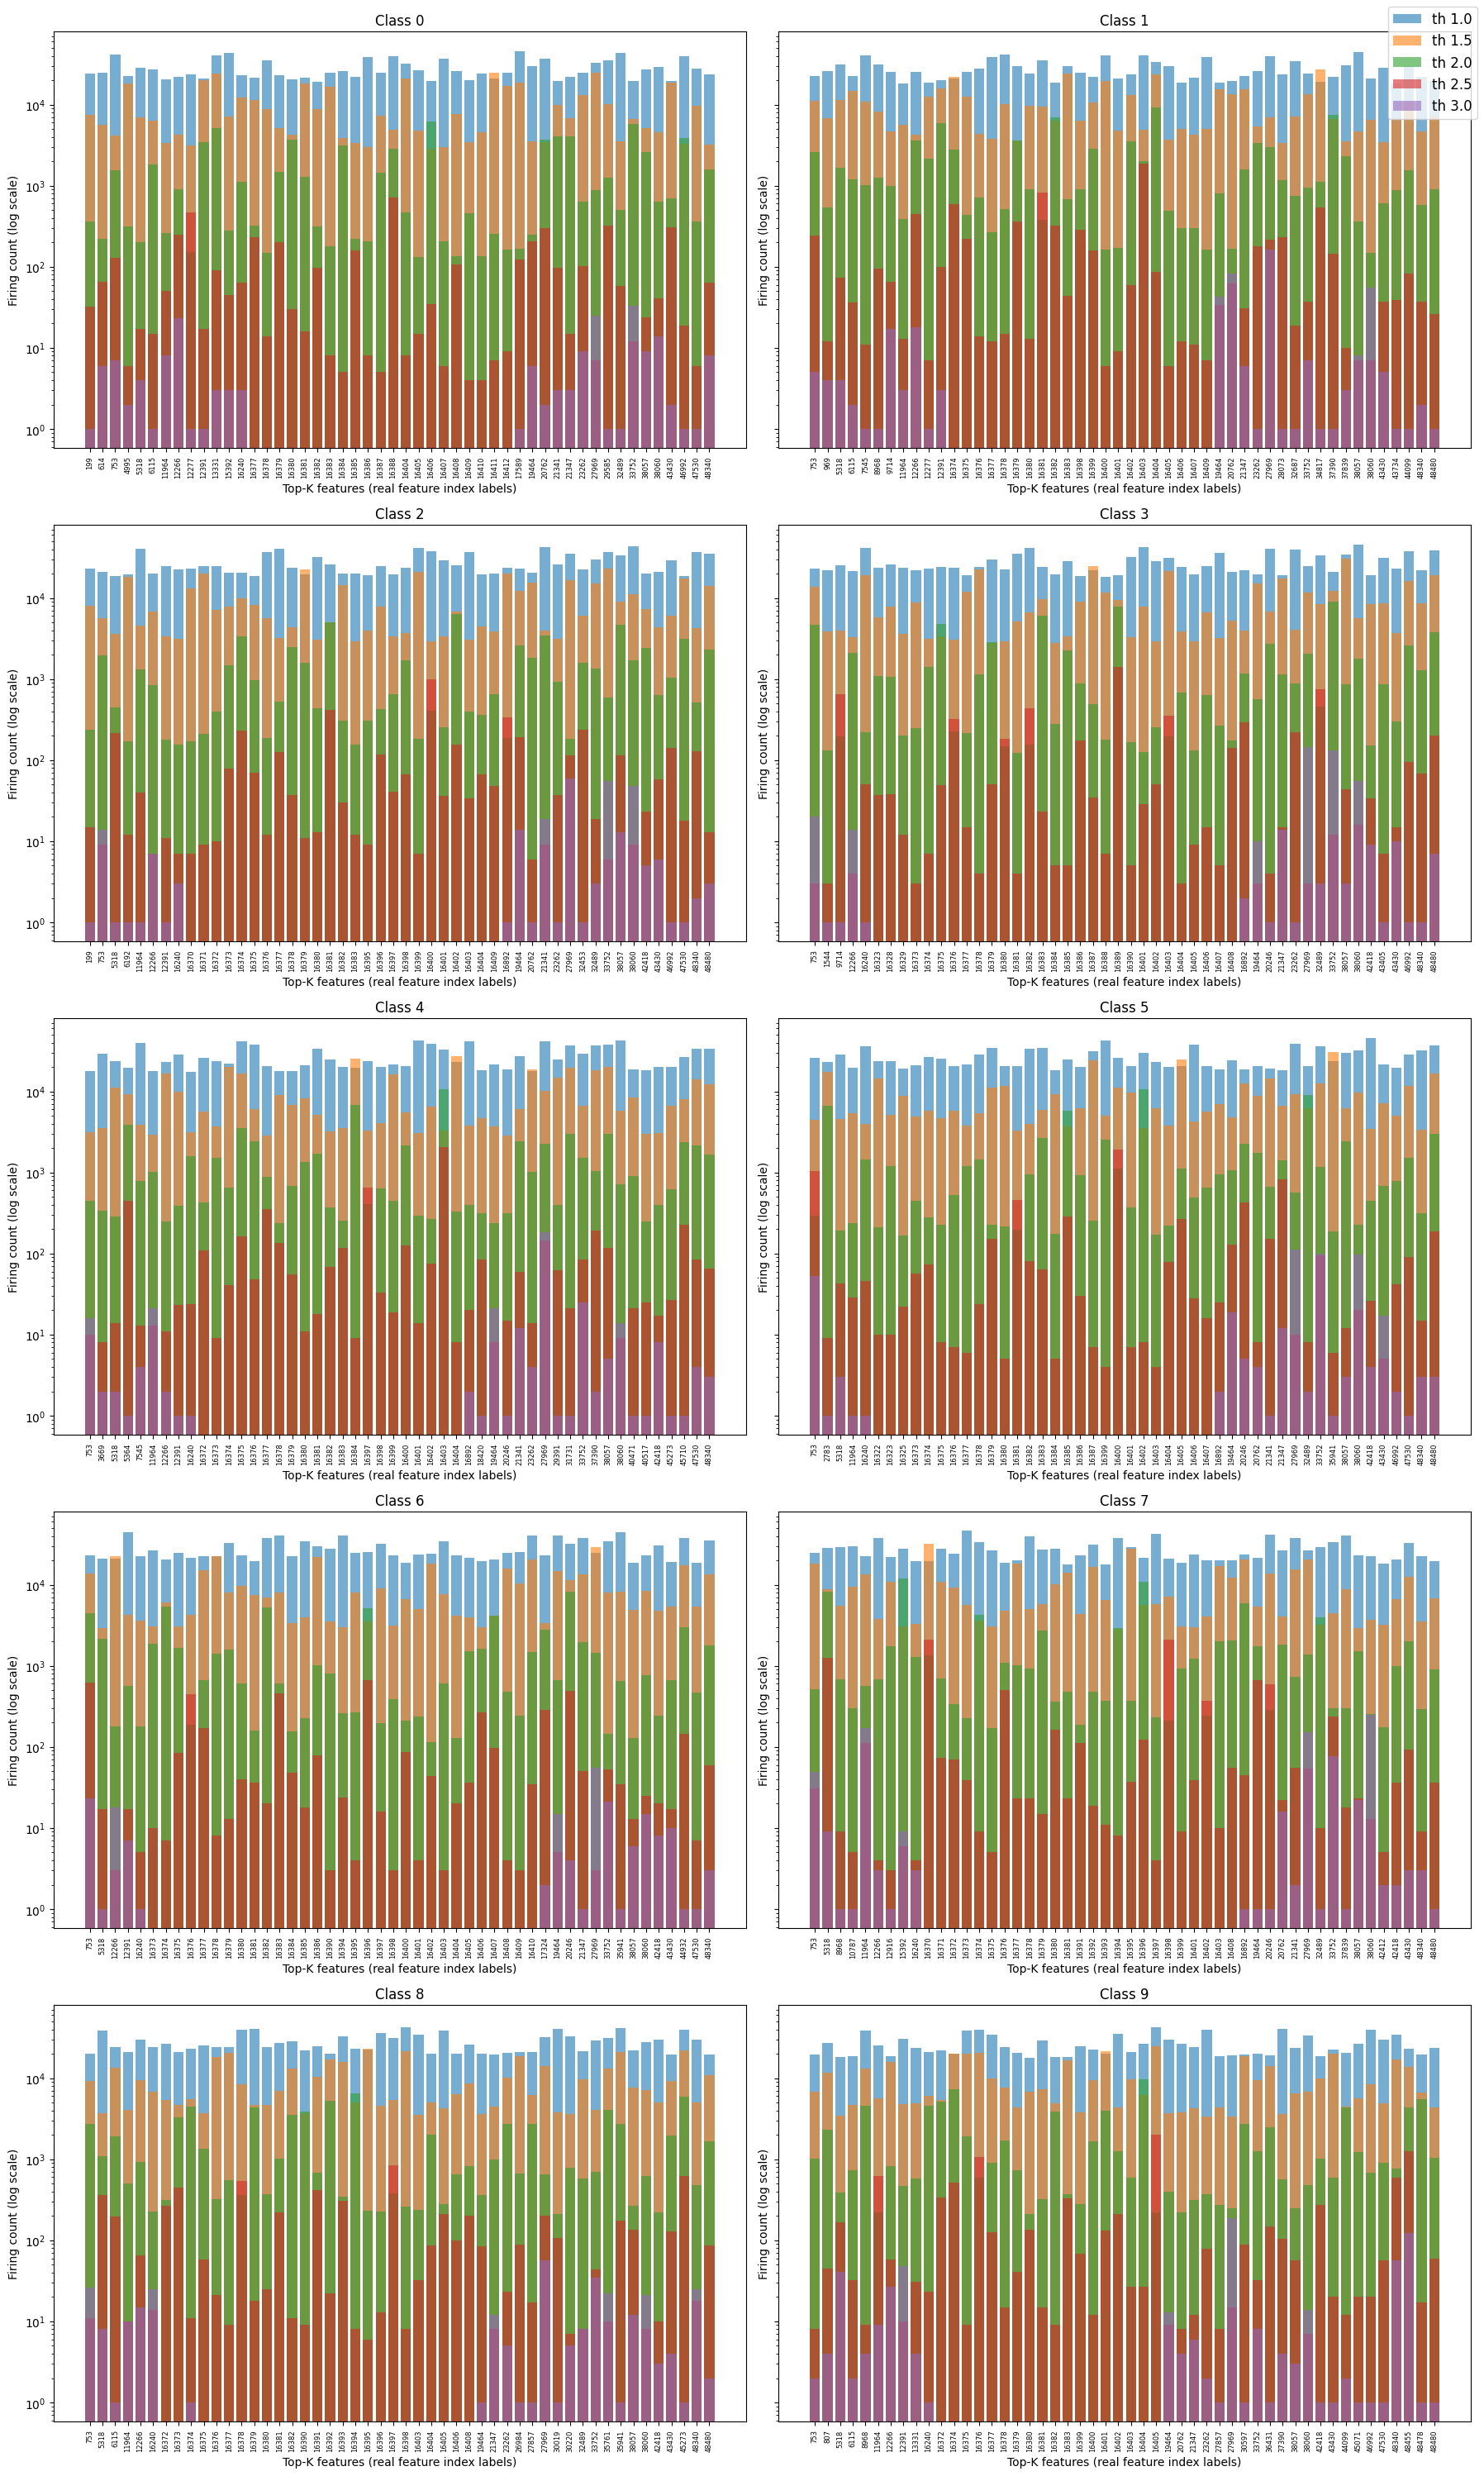

In [19]:
plot_top_features(counts, thresholds)

In [21]:
def plot_feature_rank_range(
    counts_dict,
    thresholds,
    rank_start=0,
    rank_end=50
):
    """
    Plot features ranked [rank_start, rank_end) by activation value.
    These features are reindexed to x=0..(end-start-1),
    but tick labels show real feature indices.
    Arranged as a 5x2 grid with log-scale y-axis.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    K = rank_end - rank_start
    assert K > 0, "rank_end must be greater than rank_start"

    classes = sorted(counts_dict[thresholds[0]].keys())
    fig, axes = plt.subplots(5, 2, figsize=(18, 30), sharey=True)
    axes = axes.flatten()

    for ax, class_id in zip(axes, classes):

        for th in thresholds:
            vec = counts_dict[th][class_id].cpu().numpy()

            # ---- Step 1: take top rank_end features ----
            topN_idx = np.argpartition(vec, -rank_end)[-rank_end:]
            topN_vals = vec[topN_idx]

            # ---- Step 2: sort those rank_end features by value descending ----
            order = np.argsort(-topN_vals)
            sorted_idx = topN_idx[order]
            sorted_vals = topN_vals[order]

            # ---- Step 3: slice range [rank_start, rank_end) ----
            selected_idx = sorted_idx[rank_start:rank_end]
            selected_vals = sorted_vals[rank_start:rank_end]

            # ---- Step 4: sort by actual feature index for readability ----
            order2 = np.argsort(selected_idx)
            selected_idx = selected_idx[order2]
            selected_vals = selected_vals[order2]

            # ---- Reindexed positions for plotting ----
            x = np.arange(K)

            ax.bar(x, selected_vals, alpha=0.6, label=f"th {th}")

        # x-axis shows the REAL feature indices
        ax.set_xticks(x)
        ax.set_xticklabels(selected_idx, rotation=90, fontsize=6)

        ax.set_title(f"Class {class_id}", fontsize=12)
        ax.set_xlabel(f"Features ranked {rank_start}–{rank_end} "
                      "(labeled by real feature index)")
        ax.set_ylabel("Firing count (log scale)")
        ax.set_yscale("log")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", fontsize=12)

    plt.tight_layout()
    plt.show()


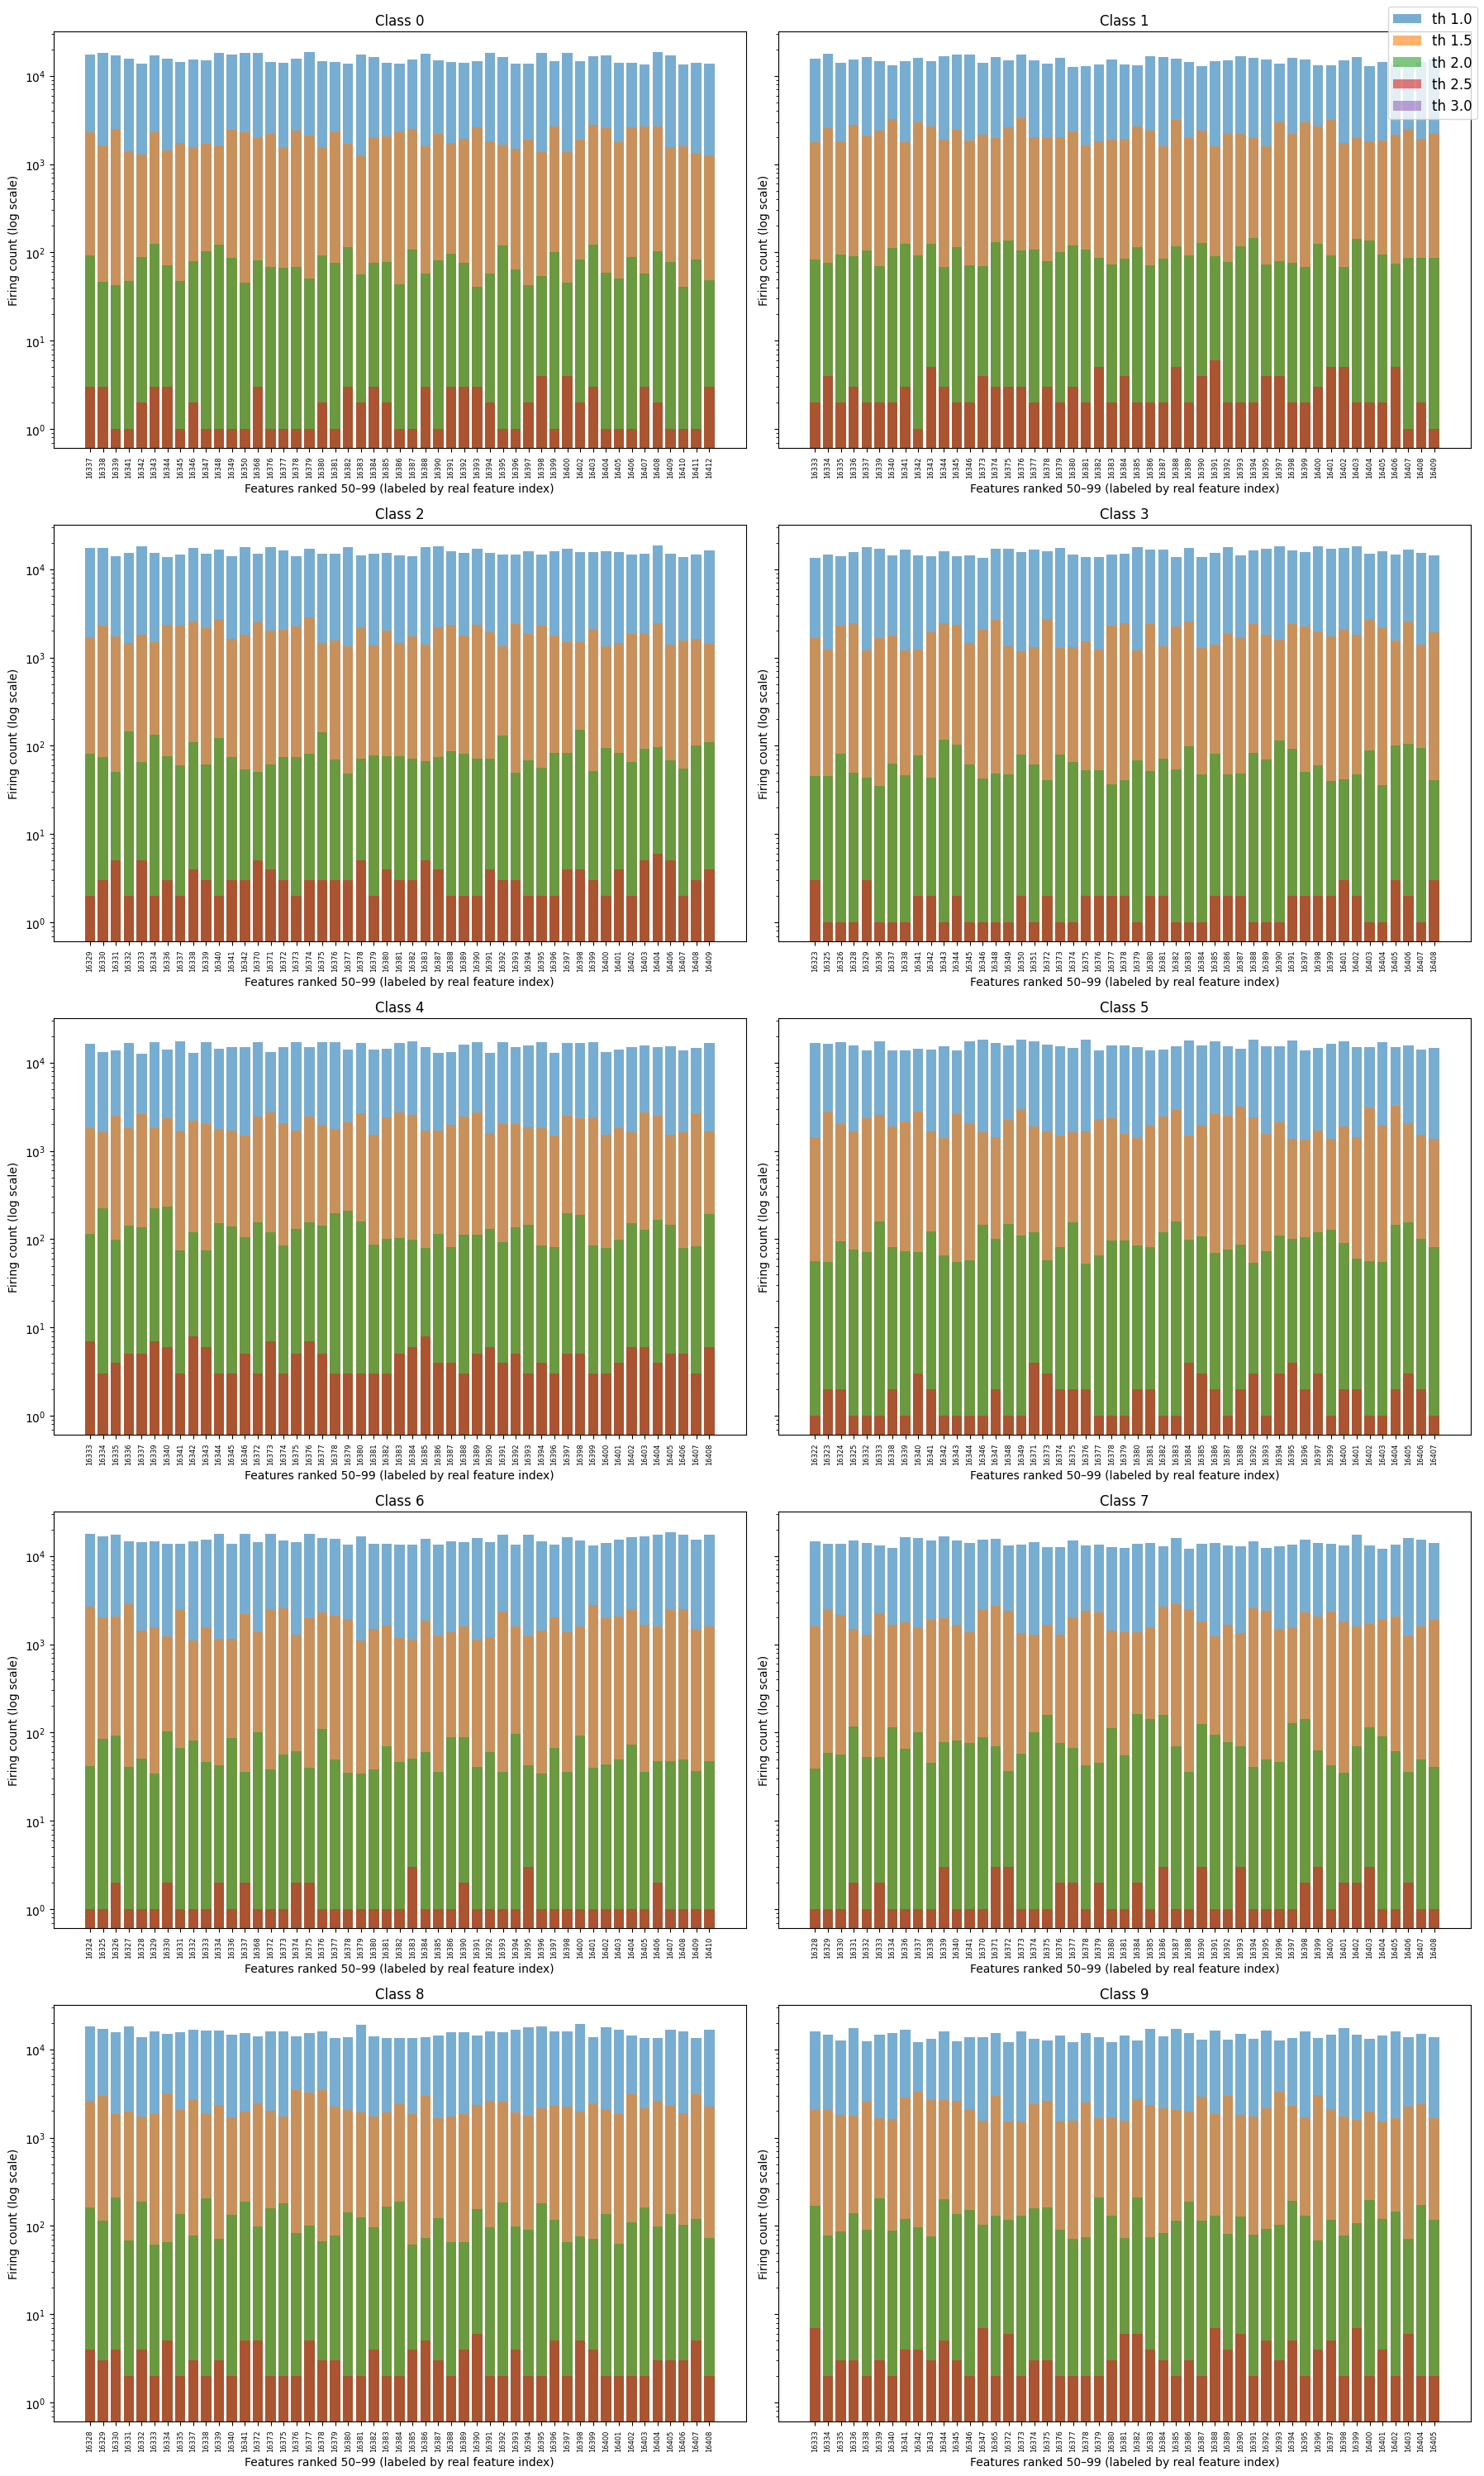

In [22]:
plot_feature_rank_range(counts,thresholds,rank_start=50,rank_end=99)

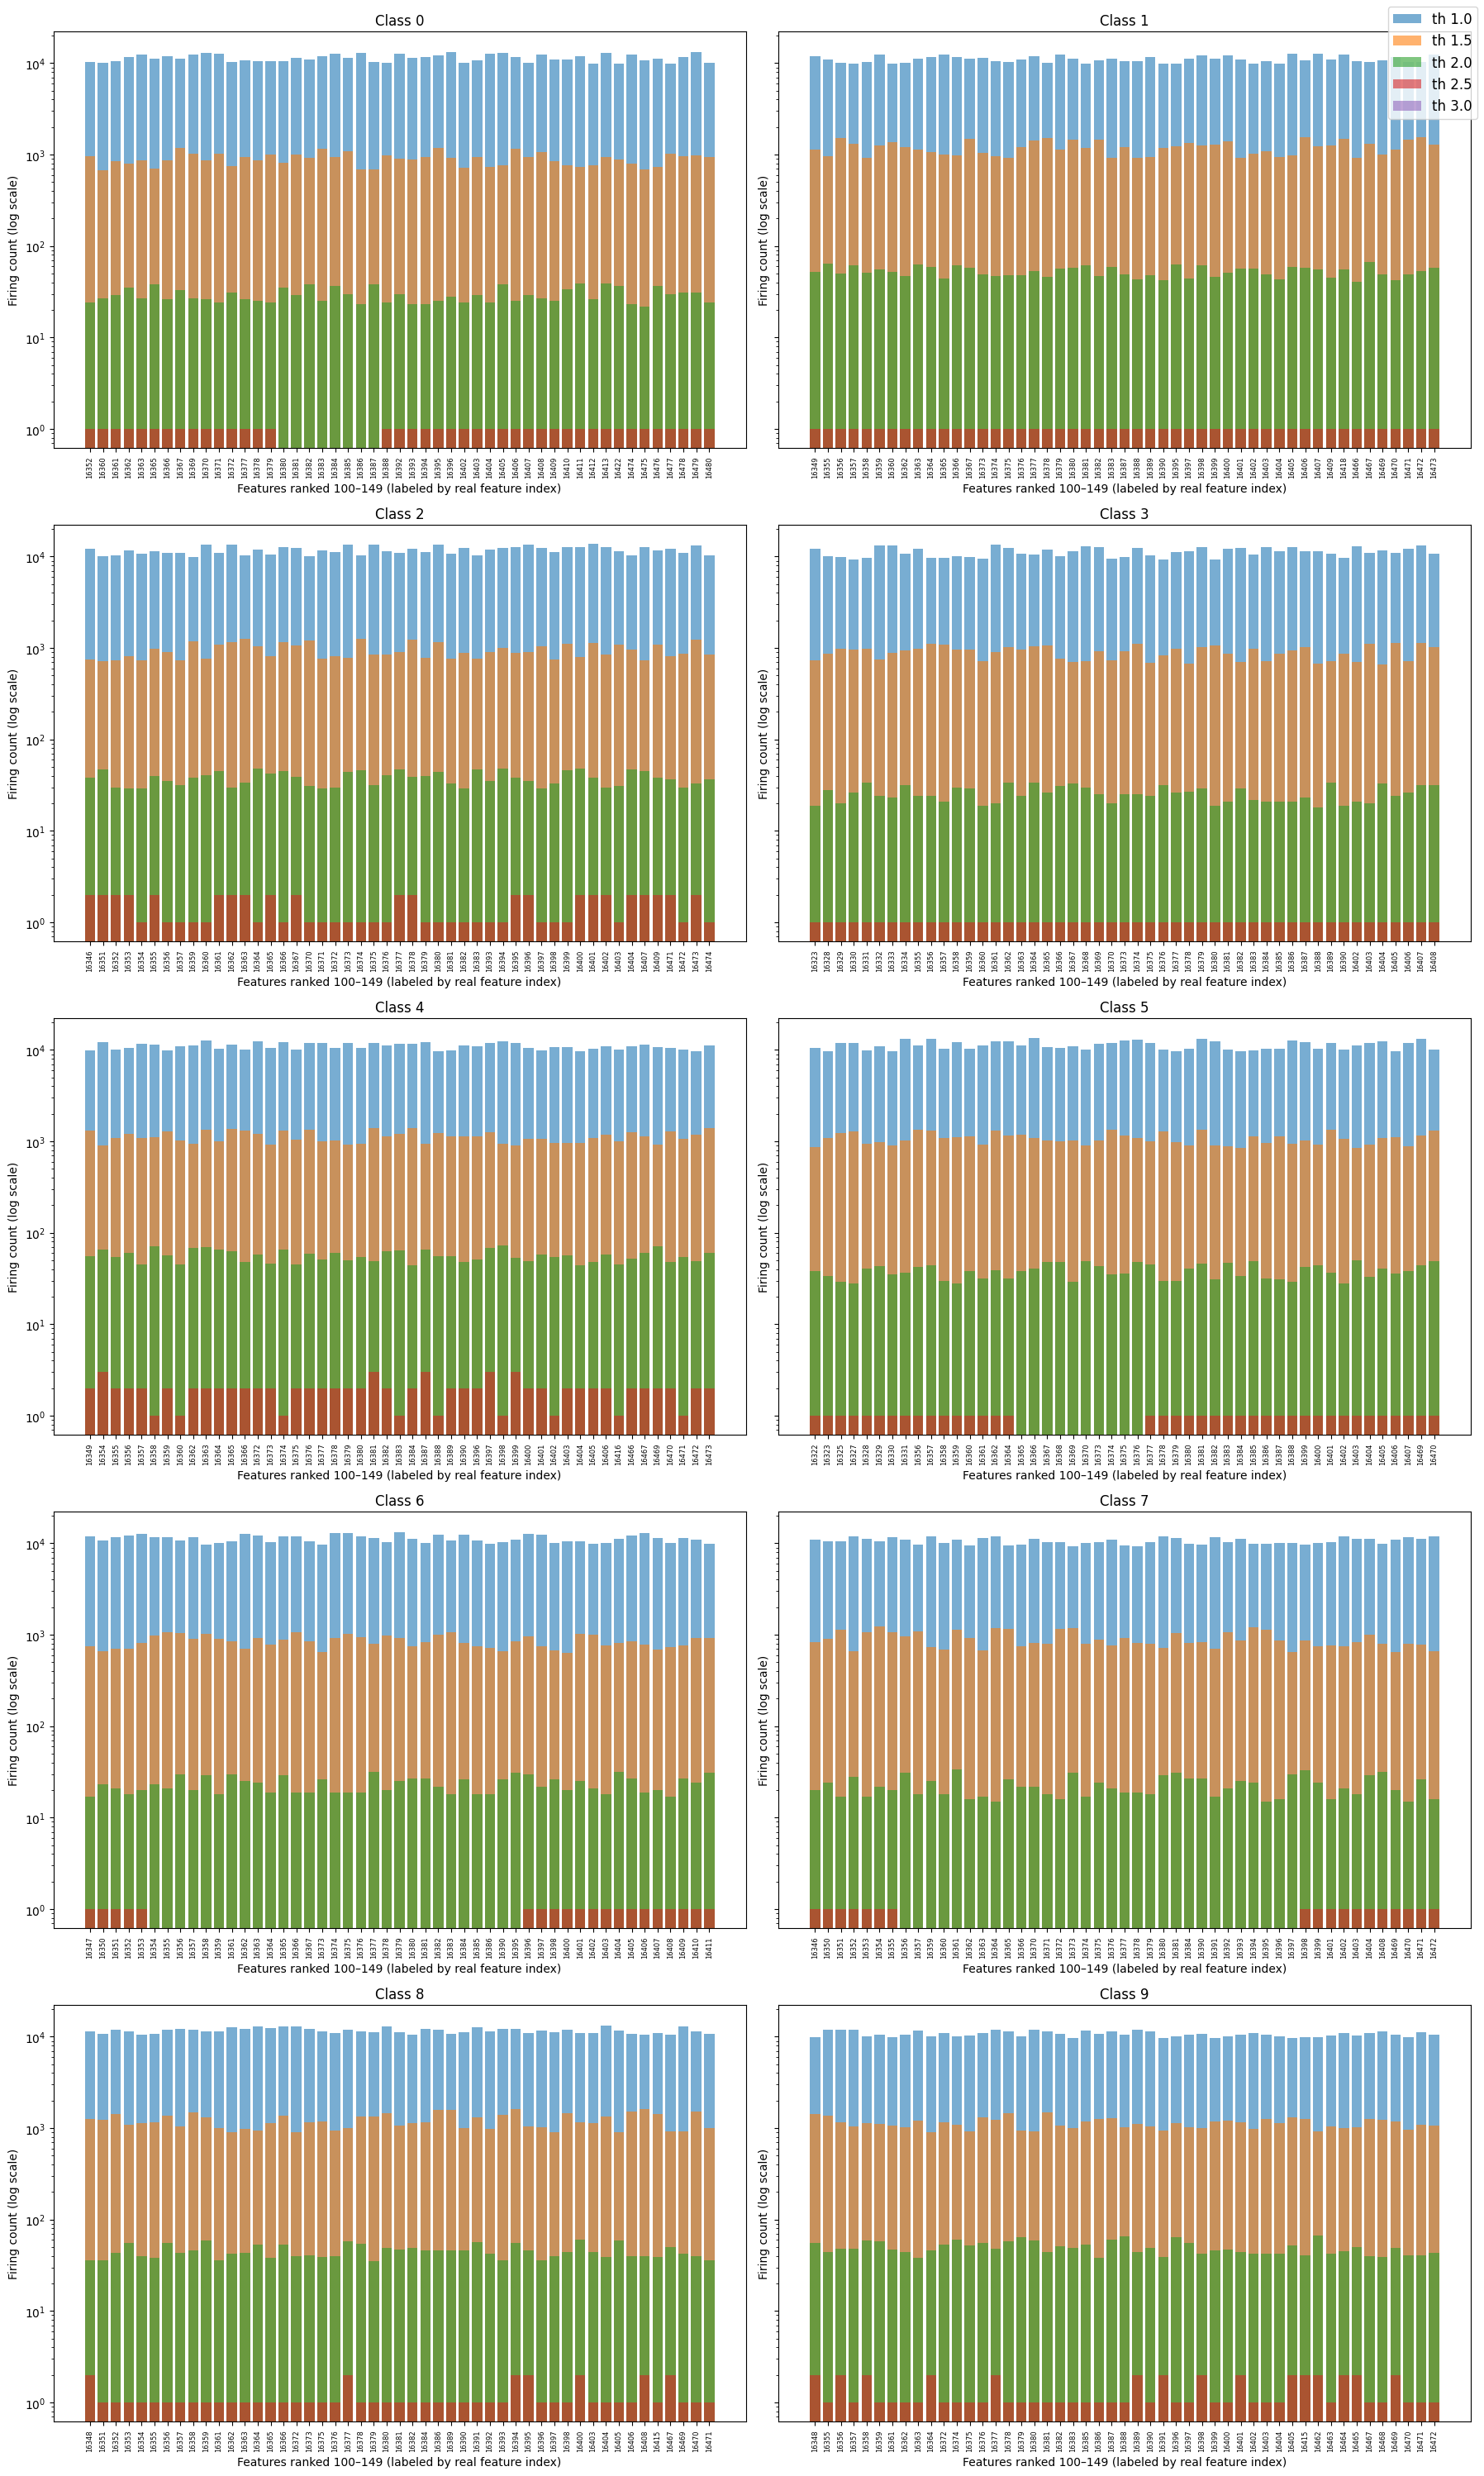

In [23]:
plot_feature_rank_range(counts,thresholds,rank_start=100,rank_end=149)

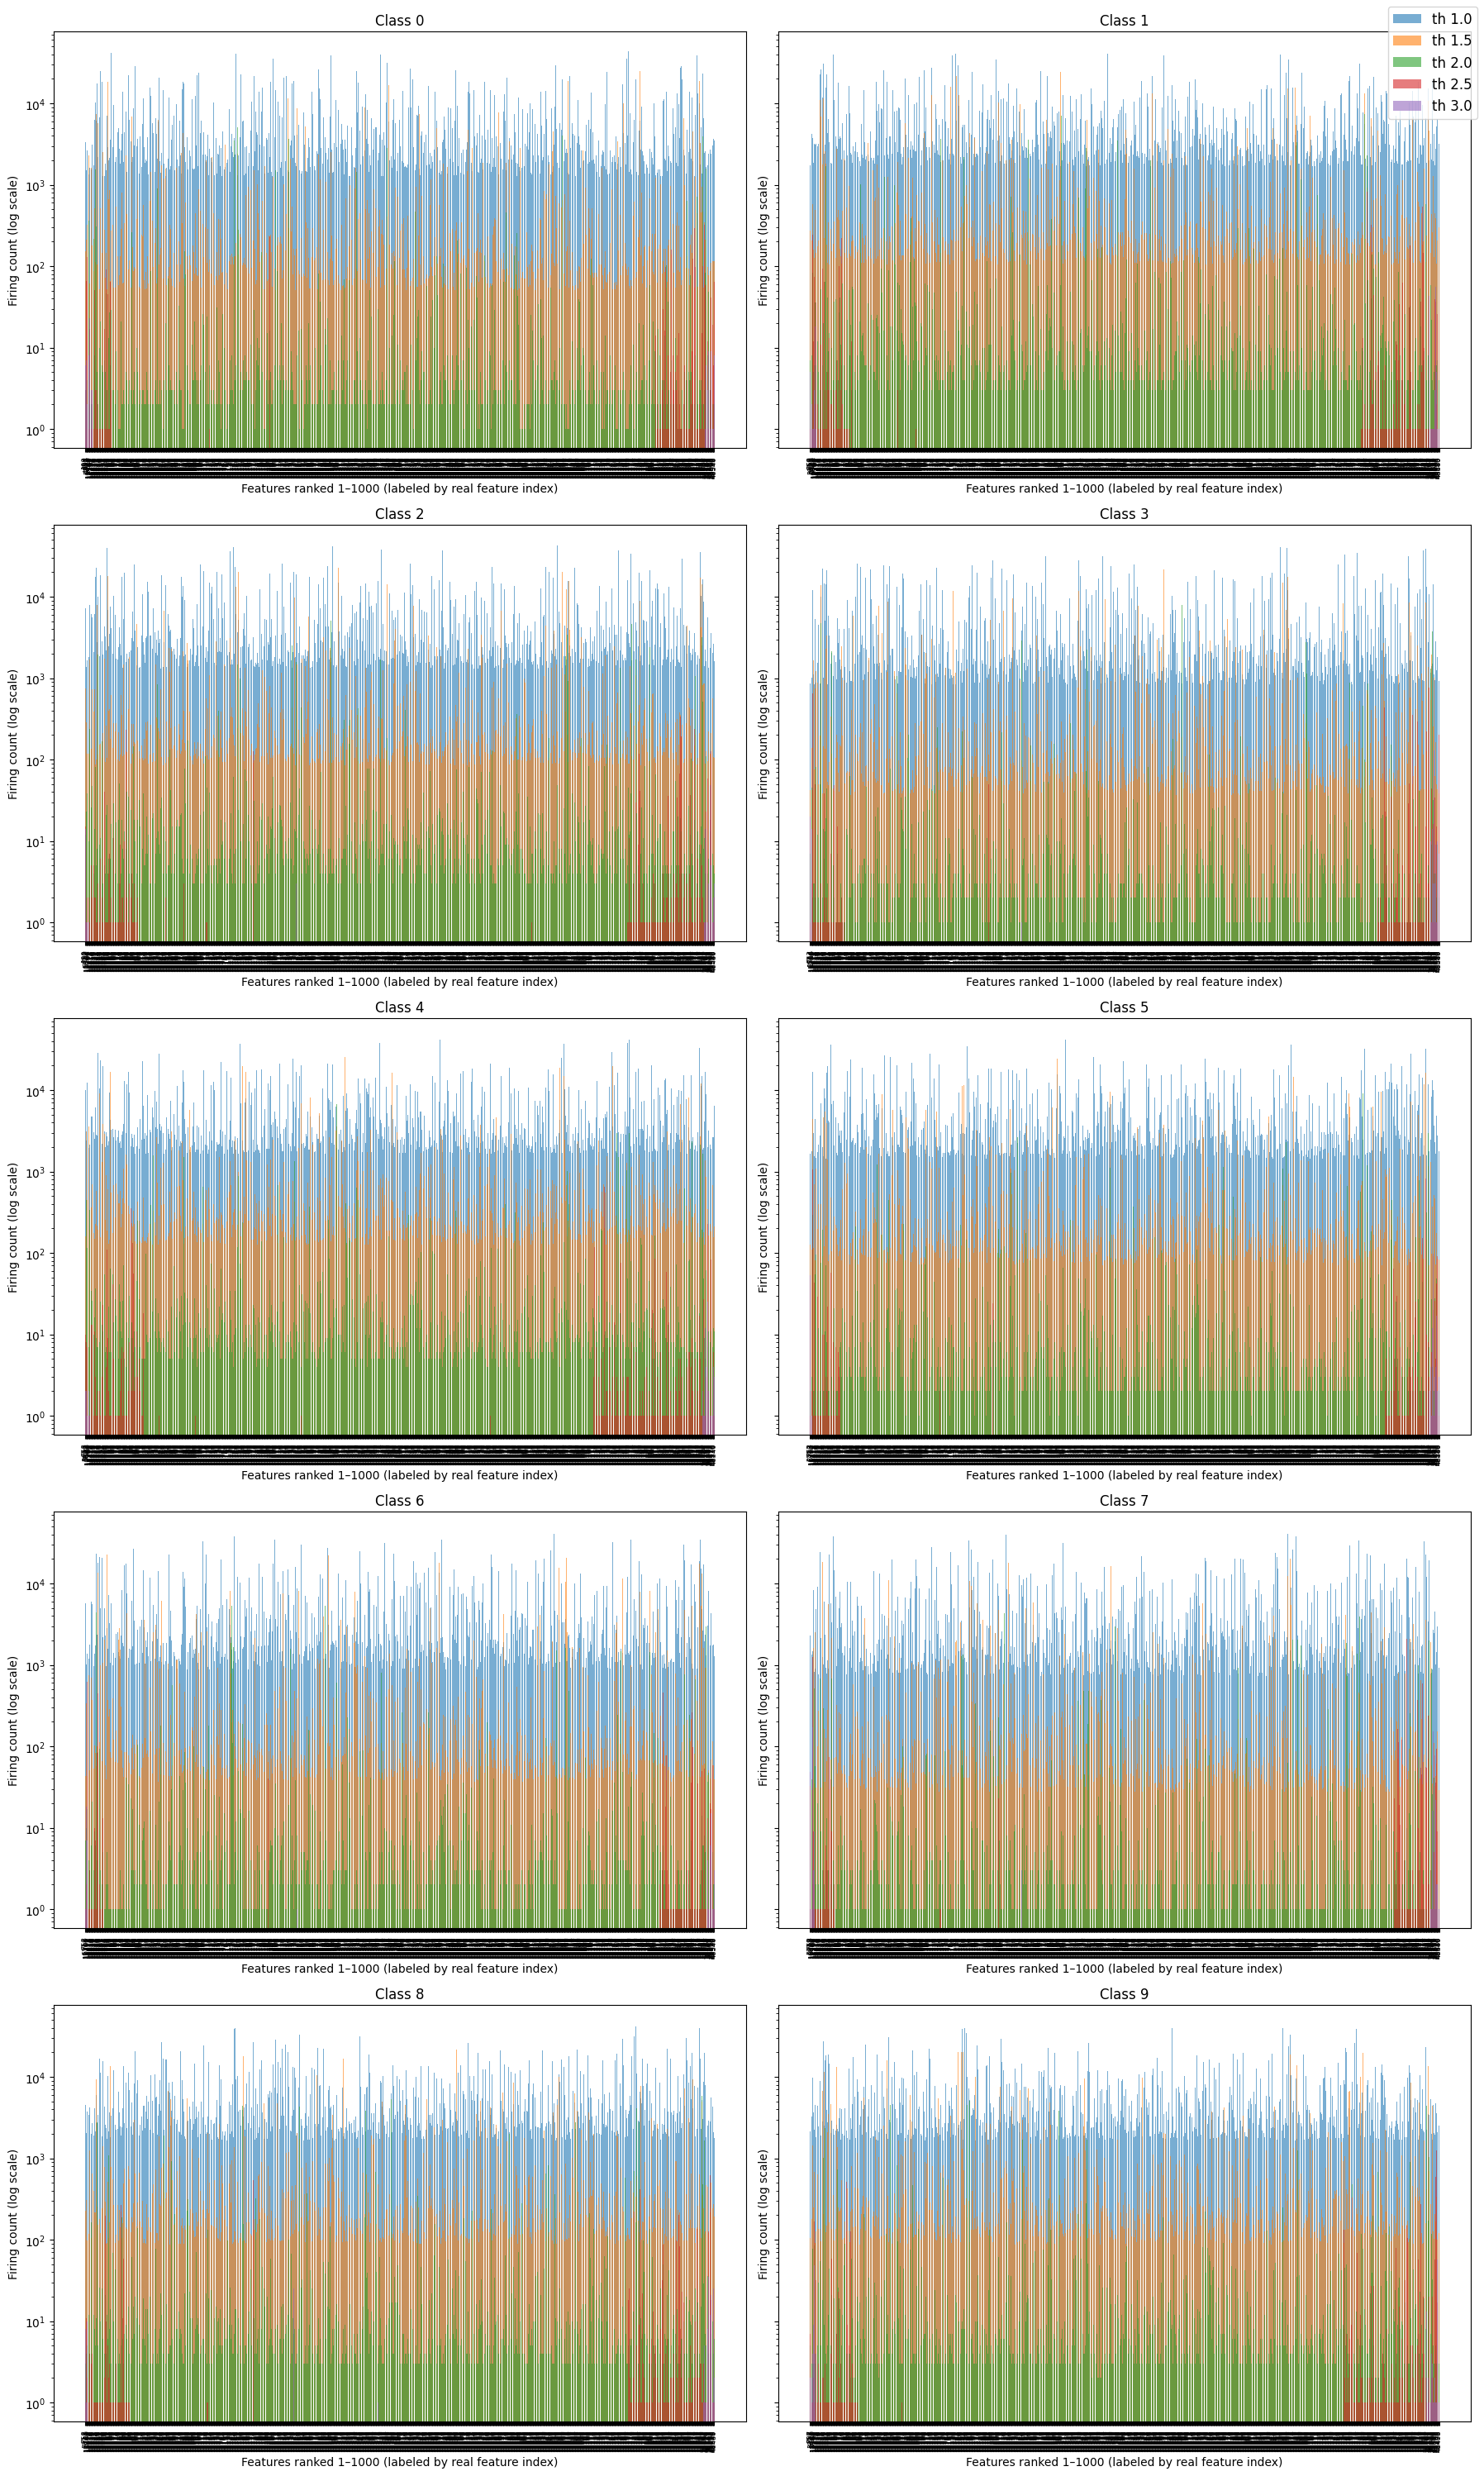

In [24]:
plot_feature_rank_range(counts,thresholds,rank_start=1,rank_end=1000)

# Visualization global top-k

In [26]:
def plot_global_rank_range(
    counts_dict,
    thresholds,
    rank_start=0,
    rank_end=50,
    aggregate="sum"   # "sum" or "mean"
):
    """
    1. Compute a GLOBAL ranking of features across *all classes and thresholds*.
    2. Select features ranked [rank_start, rank_end).
    3. For each class, plot those same feature indices (reindexed 0..K-1).
    4. 5x2 vertical layout + log scale.

    aggregate: how to aggregate across classes:
        "sum"  = sum over classes & thresholds
        "mean" = average over classes & thresholds
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # -------------------------------
    # Step 1: Aggregate feature counts globally
    # -------------------------------
    thresholds_list = list(thresholds)
    classes = sorted(counts_dict[thresholds_list[0]].keys())

    # Grab a sample vector to know number of features
    example_vec = counts_dict[thresholds_list[0]][classes[0]].cpu().numpy()
    num_features = example_vec.shape[0]

    global_accumulator = np.zeros(num_features, dtype=float)
    count_entries = 0

    for th in thresholds_list:
        for cls in classes:
            v = counts_dict[th][cls].cpu().numpy()

            if aggregate == "sum":
                global_accumulator += v
            elif aggregate == "mean":
                global_accumulator += v
                count_entries += 1

    if aggregate == "mean":
        global_accumulator /= count_entries

    # -------------------------------
    # Step 2: Compute global feature ranking
    # -------------------------------
    assert rank_end > rank_start
    K = rank_end - rank_start

    # Get top rank_end globally
    topN_idx = np.argpartition(global_accumulator, -rank_end)[-rank_end:]
    topN_vals = global_accumulator[topN_idx]

    # Sort descending by global activation
    order = np.argsort(-topN_vals)
    sorted_idx_global = topN_idx[order]
    sorted_vals_global = topN_vals[order]

    # Select global rank range
    selected_idx_global = sorted_idx_global[rank_start:rank_end]

    # Sort selected features by actual index for readability
    order2 = np.argsort(selected_idx_global)
    selected_idx_global = selected_idx_global[order2]

    # -------------------------------
    # Step 3: Plot each class's activation on those same features
    # -------------------------------
    fig, axes = plt.subplots(5, 2, figsize=(18, 30), sharey=True)
    axes = axes.flatten()

    x = np.arange(K)

    for ax, class_id in zip(axes, classes):

        for th in thresholds_list:
            vec = counts_dict[th][class_id].cpu().numpy()

            # pull values for globally-selected features
            vals = vec[selected_idx_global]

            ax.bar(x, vals, alpha=0.6, label=f"th {th}")

        # Labels = real feature indices
        ax.set_xticks(x)
        ax.set_xticklabels(selected_idx_global, rotation=90, fontsize=6)

        ax.set_title(f"Class {class_id}", fontsize=12)
        ax.set_xlabel(f"Global feature ranks {rank_start}–{rank_end} "
                      "(labeled by real feature index)")
        ax.set_ylabel("Firing count (log scale)")
        ax.set_yscale("log")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", fontsize=12)

    plt.tight_layout()
    plt.show()

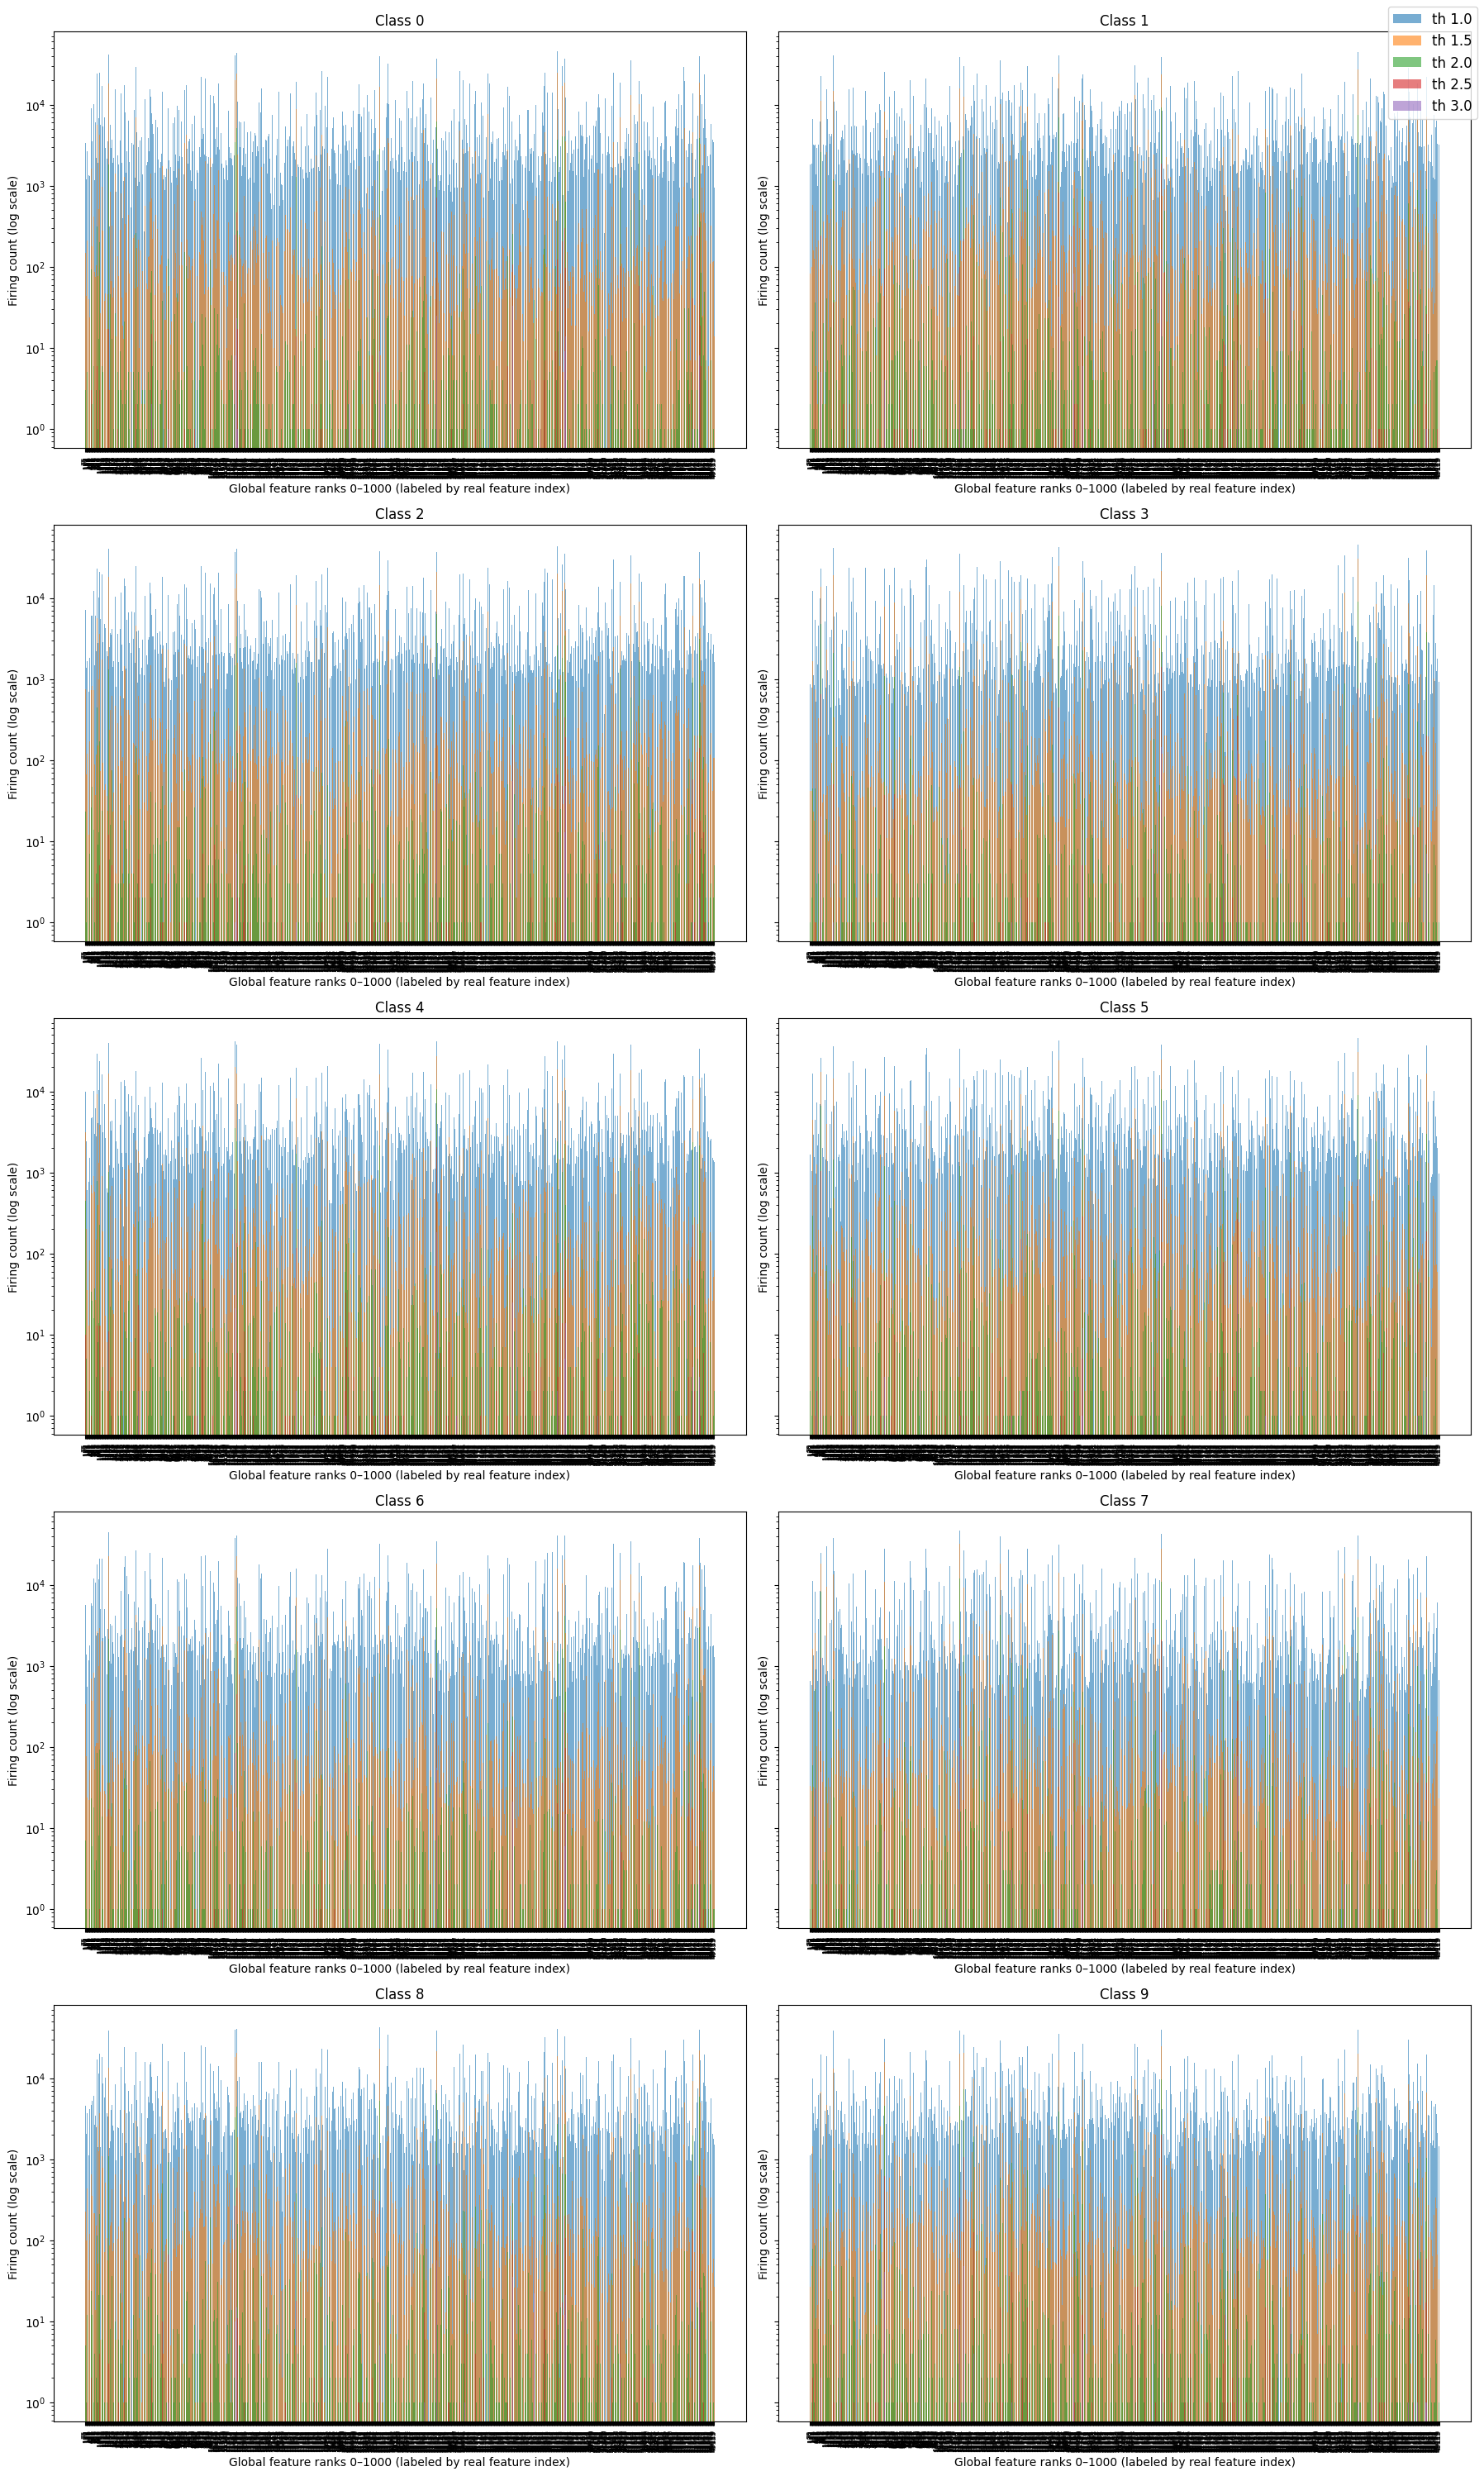

In [28]:
plot_global_rank_range(counts,thresholds,rank_start=0,rank_end=1000)

In [32]:
def plot_per_class_rank_range_concat(
    counts_dict,
    thresholds,
    rank_start=0,
    rank_end=50
):
    """
    For each class:
        - Compute a ranking of its features by activation (aggregated over thresholds)
        - Select the feature slice [rank_start, rank_end)
    Concatenate slices across classes IN ORDER, removing duplicates but
    preserving the first appearance order.

    Then for each class, plot activation for the SAME deduped feature list.

    Layout: 5x2 vertical, log-scale y-axis.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    thresholds_list = list(thresholds)
    classes = sorted(counts_dict[thresholds_list[0]].keys())

    slice_size = rank_end - rank_start
    assert slice_size > 0, "rank_end must be greater than rank_start"

    # ---------------------------------------------------------
    # Step 1: Build ordered, deduplicated concatenation
    # ---------------------------------------------------------
    ordered_unique_features = []
    seen = set()

    for class_id in classes:

        # ---- Aggregate thresholds for ranking ----
        combined = None
        for th in thresholds_list:
            vec = counts_dict[th][class_id].cpu().numpy()
            combined = vec if combined is None else combined + vec

        # ---- Sort all features by descending activation ----
        rank_order = np.argsort(-combined)

        # ---- Select [rank_start, rank_end) slice ----
        selected_slice = rank_order[rank_start:rank_end]

        # ---- Append while preserving order but removing duplicates ----
        for f in selected_slice:
            if f not in seen:
                seen.add(f)
                ordered_unique_features.append(f)

    ordered_unique_features = np.array(ordered_unique_features)
    M = len(ordered_unique_features)

    print(f"Deduped concatenation size = {M} features "
          f"(from ranks {rank_start}-{rank_end-1} of each class)")

    # ---------------------------------------------------------
    # Step 2: Prepare plot grid
    # ---------------------------------------------------------
    fig, axes = plt.subplots(5, 2, figsize=(18, 30), sharey=True)
    axes = axes.flatten()

    x = np.arange(M)

    # ---------------------------------------------------------
    # Step 3: Plot each class using the SAME deduped feature set
    # ---------------------------------------------------------
    for ax, class_id in zip(axes, classes):

        for th in thresholds_list:
            vec = counts_dict[th][class_id].cpu().numpy()
            vals = vec[ordered_unique_features]

            ax.bar(x, vals, alpha=0.6, label=f"th {th}")

        # x-axis = real feature indices
        ax.set_xticks(x)
        ax.set_xticklabels(ordered_unique_features,
                           rotation=90, fontsize=6)

        ax.set_title(f"Class {class_id}", fontsize=12)
        ax.set_xlabel(
            f"Concatenated per-class ranks {rank_start}–{rank_end-1} "
            "(deduped, real feature indices)"
        )
        ax.set_ylabel("Firing count (log scale)")
        ax.set_yscale("log")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", fontsize=12)

    plt.tight_layout()
    plt.show()

Deduped concatenation size = 121 features (from ranks 100-119 of each class)


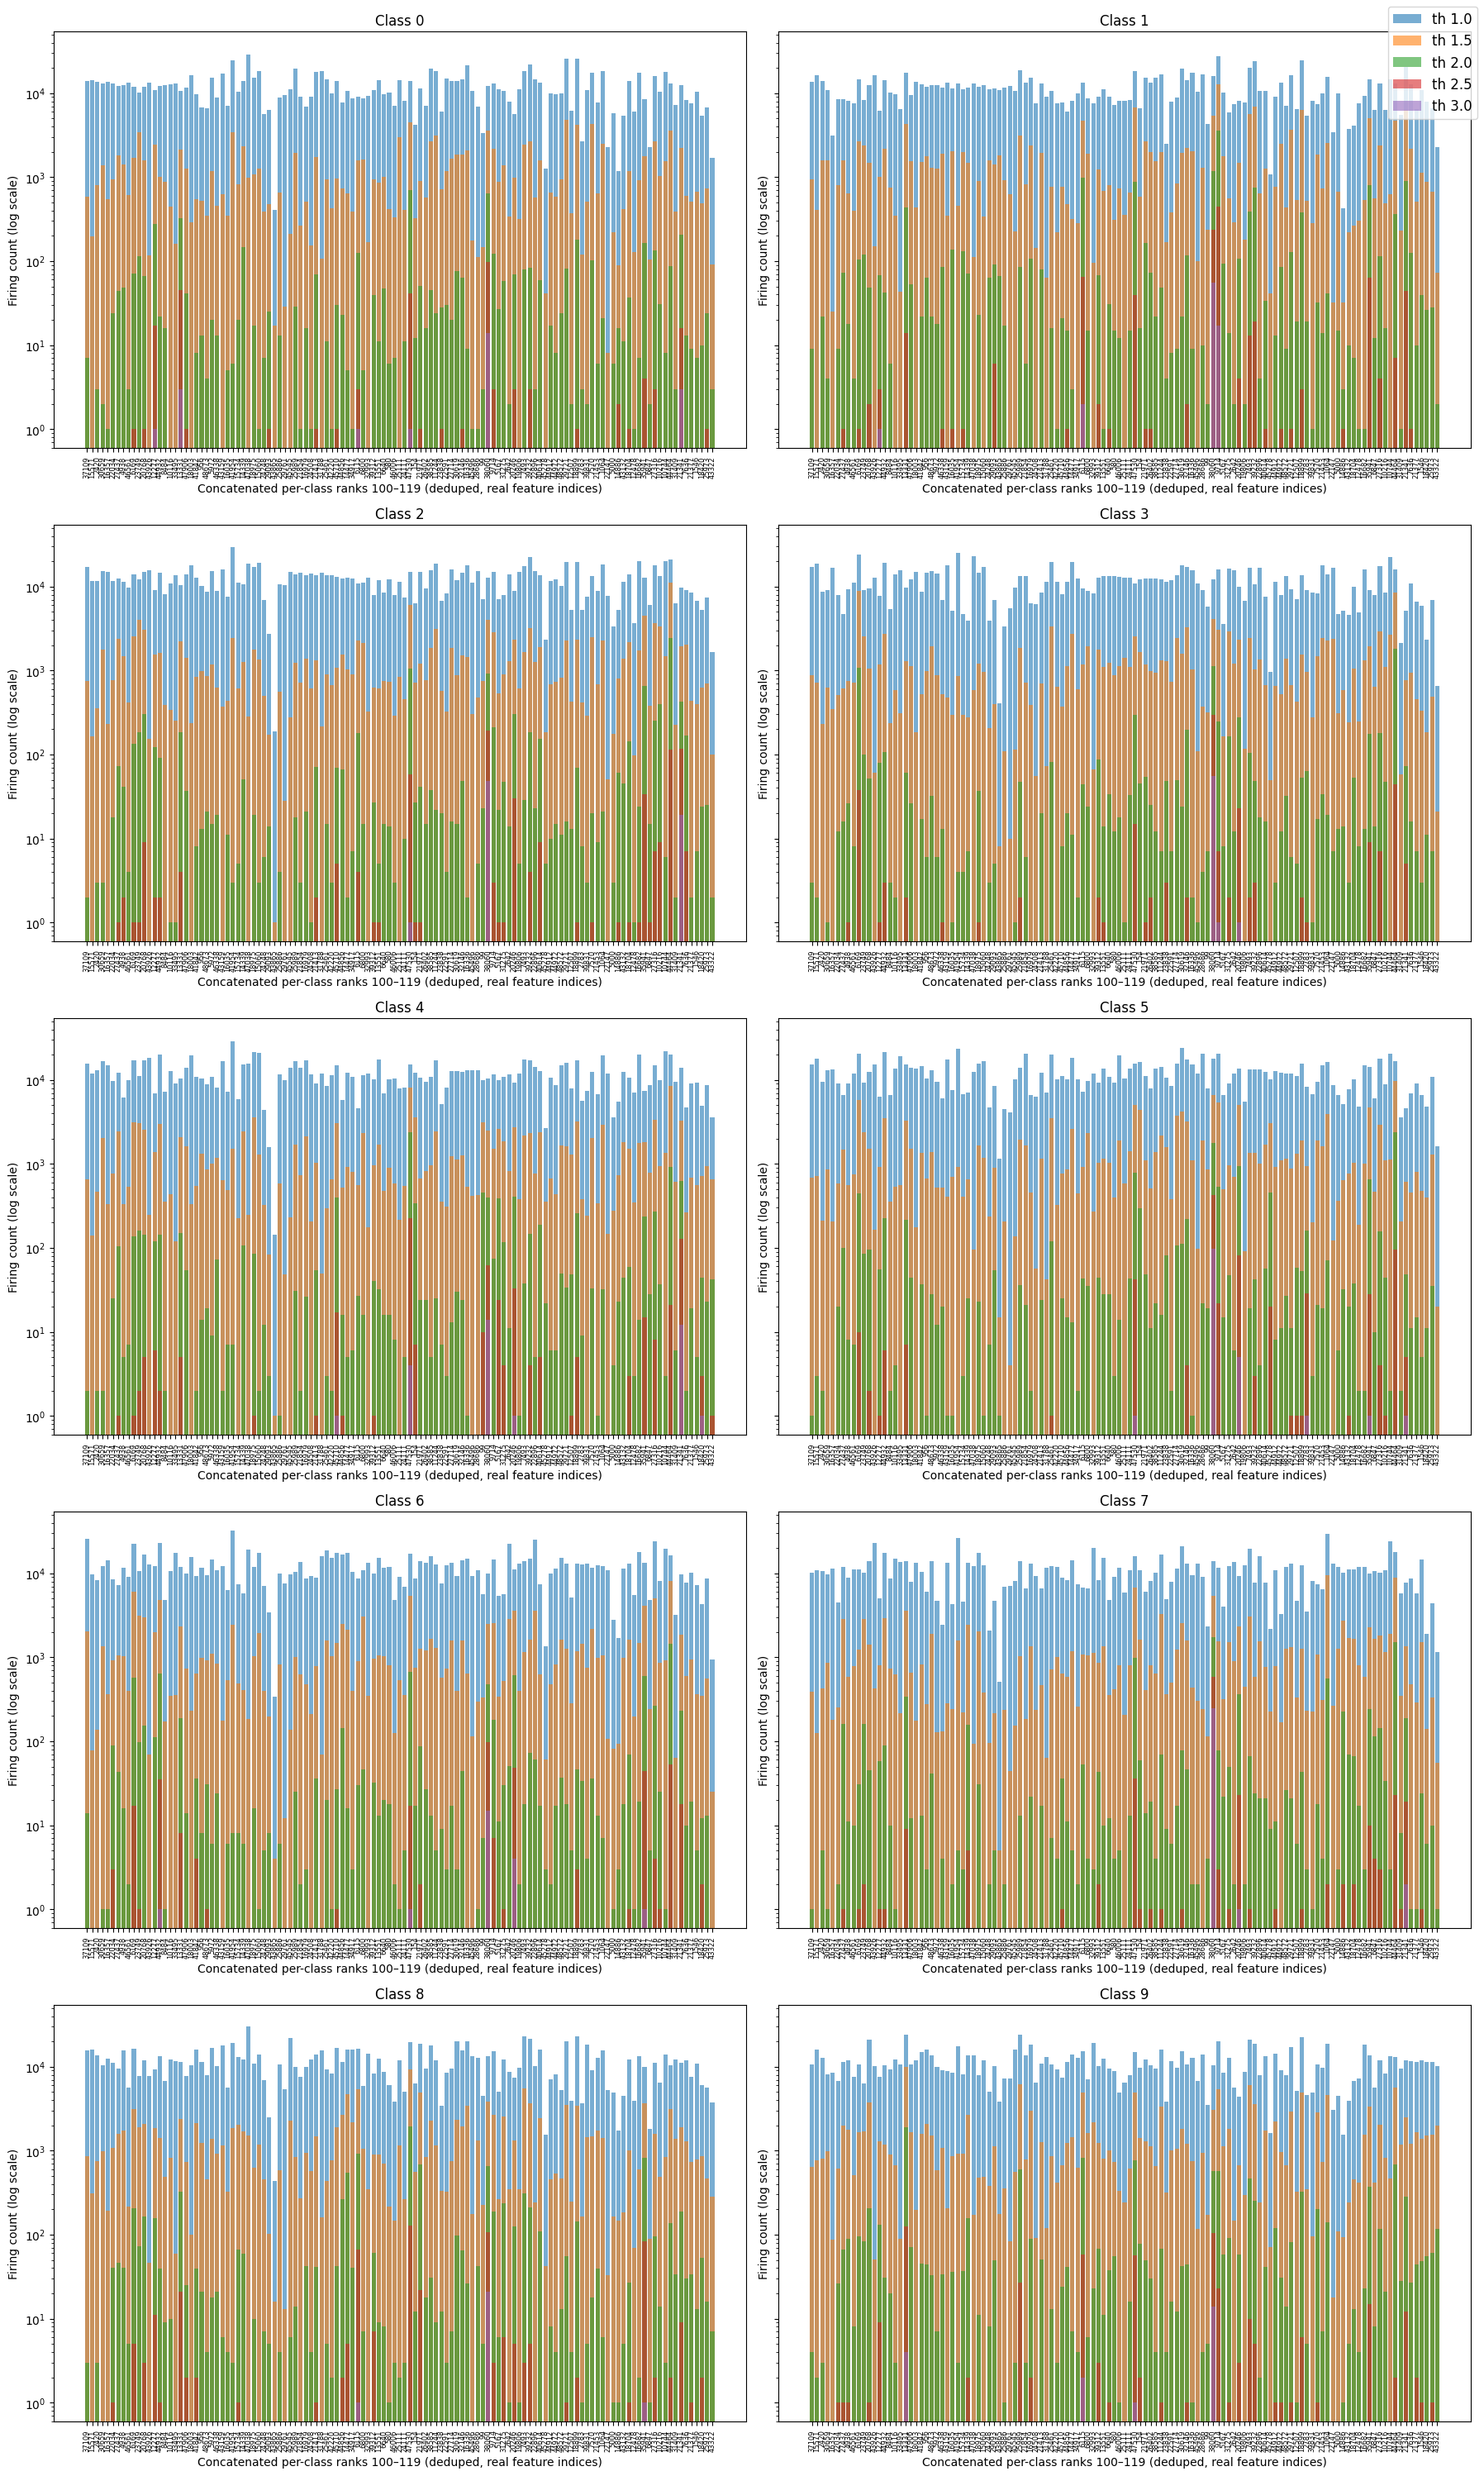

In [35]:
plot_per_class_rank_range_concat(counts,thresholds,100, 120)

# Dedupe calculations

In [36]:
def get_deduped_feature_count(
    counts_dict,
    thresholds,
    rank_start=0,
    rank_end=50
):
    """
    Returns:
        deduped_features : np.array of deduped features (ordered)
        count            : number of unique features

    Logic:
    - For each class:
        * Aggregate counts across thresholds
        * Rank features by descending activation
        * Take slice [rank_start : rank_end]
    - Concatenate all these slices in class order
    - Deduplicate while preserving appearance order
    """

    import numpy as np

    thresholds_list = list(thresholds)
    classes = sorted(counts_dict[thresholds_list[0]].keys())

    slice_size = rank_end - rank_start
    assert slice_size > 0, "rank_end must be greater than rank_start"

    ordered_unique = []
    seen = set()

    # ---------------------------------------------------------
    # Build deduped concatenation of per-class rank slices
    # ---------------------------------------------------------
    for class_id in classes:

        # Aggregate thresholds for ranking
        combined = None
        for th in thresholds_list:
            vec = counts_dict[th][class_id].cpu().numpy()
            combined = vec if combined is None else combined + vec

        # Full ranking for this class (descending)
        rank_order = np.argsort(-combined)

        # Slice the requested range
        selected_slice = rank_order[rank_start:rank_end]

        # Append deduped in order
        for f in selected_slice:
            if f not in seen:
                seen.add(f)
                ordered_unique.append(f)

    # Convert to array
    ordered_unique = np.array(ordered_unique)
    return ordered_unique, len(ordered_unique)

In [40]:
# ranges = [(0, 50),(50, 100), (100, 150), (150, 200)]
for n in range(10):
    features, count = get_deduped_feature_count(counts, thresholds, n*50, (n+1)*50)
    print(f"Total unique features for each class's {n*50}-{(n+1)*50}:", count)
    print(f"Total non-unique features for each class's {n*50}-{(n+1)*50}:", 500)

Total unique features for each class's 0-50: 102
Total non-unique features for each class's 0-50: 500
Total unique features for each class's 50-100: 161
Total non-unique features for each class's 50-100: 500
Total unique features for each class's 100-150: 212
Total non-unique features for each class's 100-150: 500
Total unique features for each class's 150-200: 245
Total non-unique features for each class's 150-200: 500
Total unique features for each class's 200-250: 288
Total non-unique features for each class's 200-250: 500
Total unique features for each class's 250-300: 314
Total non-unique features for each class's 250-300: 500
Total unique features for each class's 300-350: 331
Total non-unique features for each class's 300-350: 500
Total unique features for each class's 350-400: 344
Total non-unique features for each class's 350-400: 500
Total unique features for each class's 400-450: 385
Total non-unique features for each class's 400-450: 500
Total unique features for each class

In [50]:
import matplotlib.pyplot as plt

def plot_unique_vs_nonunique(counts, thresholds, n=10, k=50):
    """
    n = number of ranges
    k = width of each range (e.g., 50 means 0–49, 50–99, ...)
    """

    unique_counts = []
    non_unique_counts = []

    ranges = [(i * k, (i + 1) * k) for i in range(n)]

    for (start, end) in ranges:
        features, count = get_deduped_feature_count(counts, thresholds, start, end)
        unique_counts.append(count)

        # total per-class features before dedupe = k * num_classes
        num_classes = len(counts[thresholds[0]])
        non_unique_counts.append(k * num_classes)

    # x-axis
    x = list(range(n))
    labels = [f"{a}–{b}" for (a, b) in ranges]

    plt.figure(figsize=(10,6))

    plt.plot(x, unique_counts, marker='o', linewidth=3, label="Unique count")
    plt.plot(x, non_unique_counts, marker='o', linewidth=3, label="Non-unique count")

    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Feature rank range per class")
    plt.ylabel("Feature count")
    plt.title(f"Unique vs Non-Unique Counts Across {n} Ranges (size={k}) (Threshold = 1.0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # return ranges, unique_counts, non_unique_counts

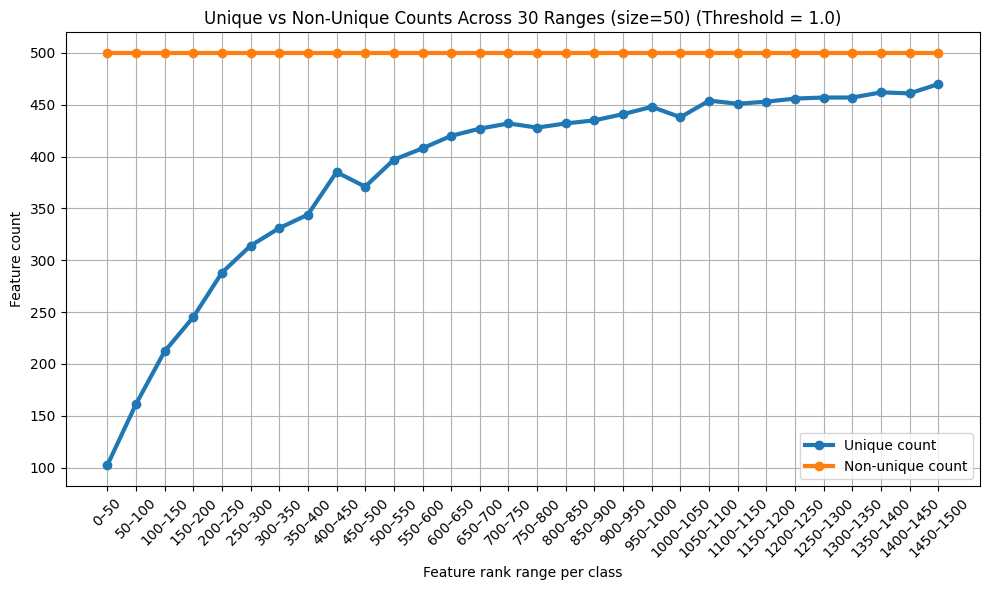

In [51]:
plot_unique_vs_nonunique(counts, thresholds, n=30, k=50)

In [47]:
import matplotlib.pyplot as plt

def plot_unique_vs_nonunique_multithreshold(counts, thresholds, n=10, k=50):
    """
    Produces a line plot:
      - x-axis = rank ranges (0–k, k–2k, ...)
      - y-axis = number of unique features after dedupe
      - one line per threshold
      - one dashed line = total non-unique features (k * num_classes)
    """

    # automatically create ranges
    ranges = [(i * k, (i + 1) * k) for i in range(n)]
    num_classes = len(counts[thresholds[0]])

    # Baseline non-unique value = k per class
    non_unique_count = k * num_classes

    # x-locations
    x = list(range(n))
    labels = [f"{a}–{b}" for (a, b) in ranges]

    plt.figure(figsize=(12, 7))

    # ----------------------------------------
    # Compute and plot unique counts PER THRESHOLD
    # ----------------------------------------
    for th in thresholds:
        unique_counts = []

        for (start, end) in ranges:
            # Just call your existing function but with only THIS threshold
            features, count = get_deduped_feature_count(
                {th: counts[th]},     # isolate one threshold
                thresholds=[th],      # single threshold
                rank_start=start,
                rank_end=end
            )
            unique_counts.append(count)

        plt.plot(x, unique_counts, marker='o', linewidth=3, label=f"Threshold {th}")

    # ----------------------------------------
    # Add non-unique line (same for all thresholds)
    # ----------------------------------------
    plt.plot(
        x,
        [non_unique_count] * n,
        '--',
        linewidth=2,
        color='black',
        label="Non-unique (baseline)"
    )

    # ----------------------------------------
    # Formatting
    # ----------------------------------------
    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Feature rank range per class")
    plt.ylabel("Feature count")
    plt.title(f"Unique vs Non-Unique Feature Counts Across {n} Ranges (size={k})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # return ranges

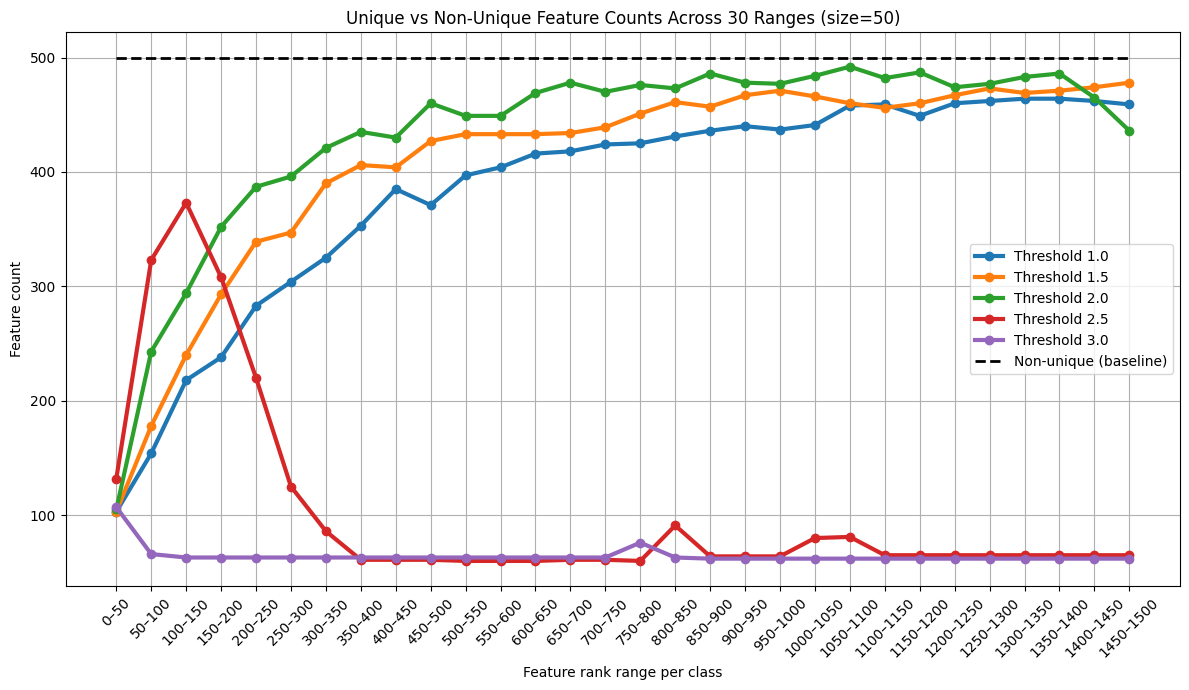

[(0, 50),
 (50, 100),
 (100, 150),
 (150, 200),
 (200, 250),
 (250, 300),
 (300, 350),
 (350, 400),
 (400, 450),
 (450, 500),
 (500, 550),
 (550, 600),
 (600, 650),
 (650, 700),
 (700, 750),
 (750, 800),
 (800, 850),
 (850, 900),
 (900, 950),
 (950, 1000),
 (1000, 1050),
 (1050, 1100),
 (1100, 1150),
 (1150, 1200),
 (1200, 1250),
 (1250, 1300),
 (1300, 1350),
 (1350, 1400),
 (1400, 1450),
 (1450, 1500)]

In [48]:
plot_unique_vs_nonunique_multithreshold(counts, thresholds, n=30, k=50)

In [52]:

def plot_unique_vs_nonunique_multithreshold_with_offset(
    counts,
    thresholds,
    global_start=100,
    bucket_size=50,
    n_buckets=10
):
    """
    Create n_buckets ranges starting from global_start:
        [global_start + i*bucket_size, global_start + (i+1)*bucket_size)

    For each threshold, compute a unique-count line across these buckets.
    Also plot the non-unique baseline.
    """

    # -----------------------------
    # Build bucket ranges
    # -----------------------------
    ranges = [
        (global_start + i * bucket_size,
         global_start + (i + 1) * bucket_size)
        for i in range(n_buckets)
    ]

    num_classes = len(counts[thresholds[0]])
    non_unique_count = bucket_size * num_classes

    x = list(range(n_buckets))
    labels = [f"{a}–{b}" for (a, b) in ranges]

    plt.figure(figsize=(12, 7))

    # -----------------------------
    # Compute per-threshold unique counts
    # -----------------------------
    for th in thresholds:
        unique_counts = []

        for (start, end) in ranges:
            # compute deduped features for THIS threshold only
            features, count = get_deduped_feature_count(
                {th: counts[th]},        # isolate this threshold
                thresholds=[th],
                rank_start=start,
                rank_end=end
            )
            unique_counts.append(count)

        plt.plot(x, unique_counts, marker='o', linewidth=3, label=f"Threshold {th}")

    # -----------------------------
    # Add baseline (non-unique count)
    # -----------------------------
    plt.plot(
        x,
        [non_unique_count] * n_buckets,
        '--', linewidth=2, color='black',
        label="Non-unique (baseline)"
    )

    # -----------------------------
    # Format plot
    # -----------------------------
    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Per-class feature rank range")
    plt.ylabel("Feature count")
    plt.title(
        f"Unique vs Non-Unique Across Buckets "
        f"(start={global_start}, size={bucket_size}, buckets={n_buckets})"
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # return ranges

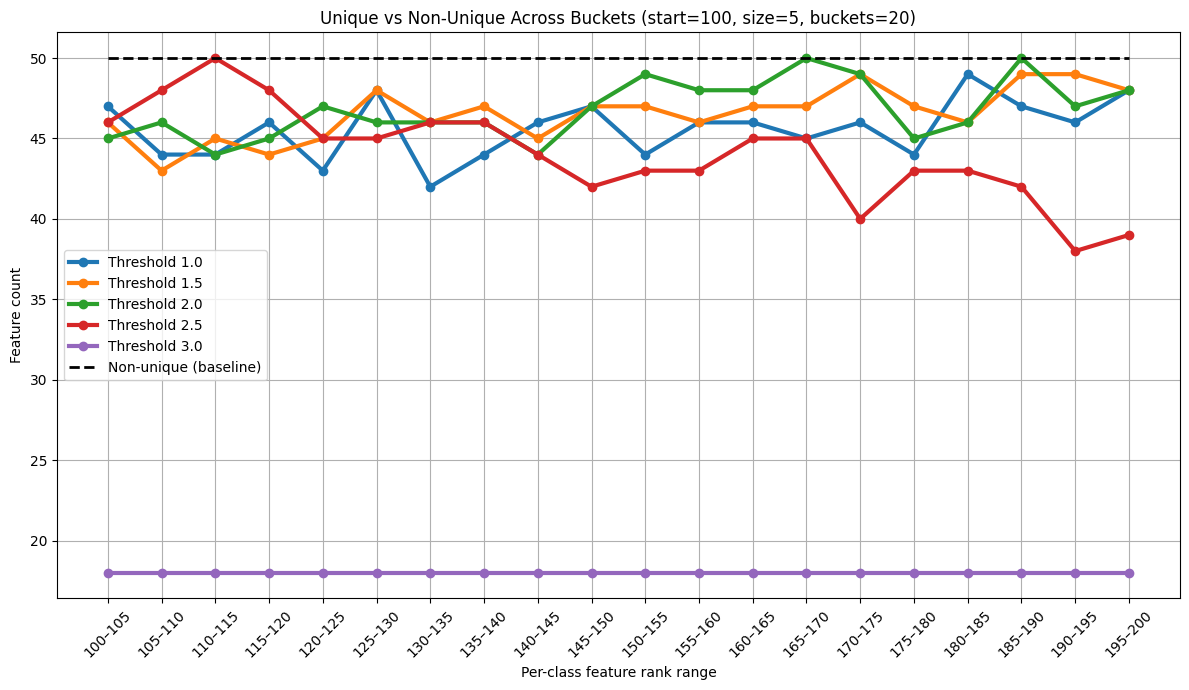

[(100, 105),
 (105, 110),
 (110, 115),
 (115, 120),
 (120, 125),
 (125, 130),
 (130, 135),
 (135, 140),
 (140, 145),
 (145, 150),
 (150, 155),
 (155, 160),
 (160, 165),
 (165, 170),
 (170, 175),
 (175, 180),
 (180, 185),
 (185, 190),
 (190, 195),
 (195, 200)]

In [59]:
plot_unique_vs_nonunique_multithreshold_with_offset(counts,thresholds,global_start=100,bucket_size=5,n_buckets=20)

Deduped concatenation size = 44 features (from ranks 100-104 of each class)


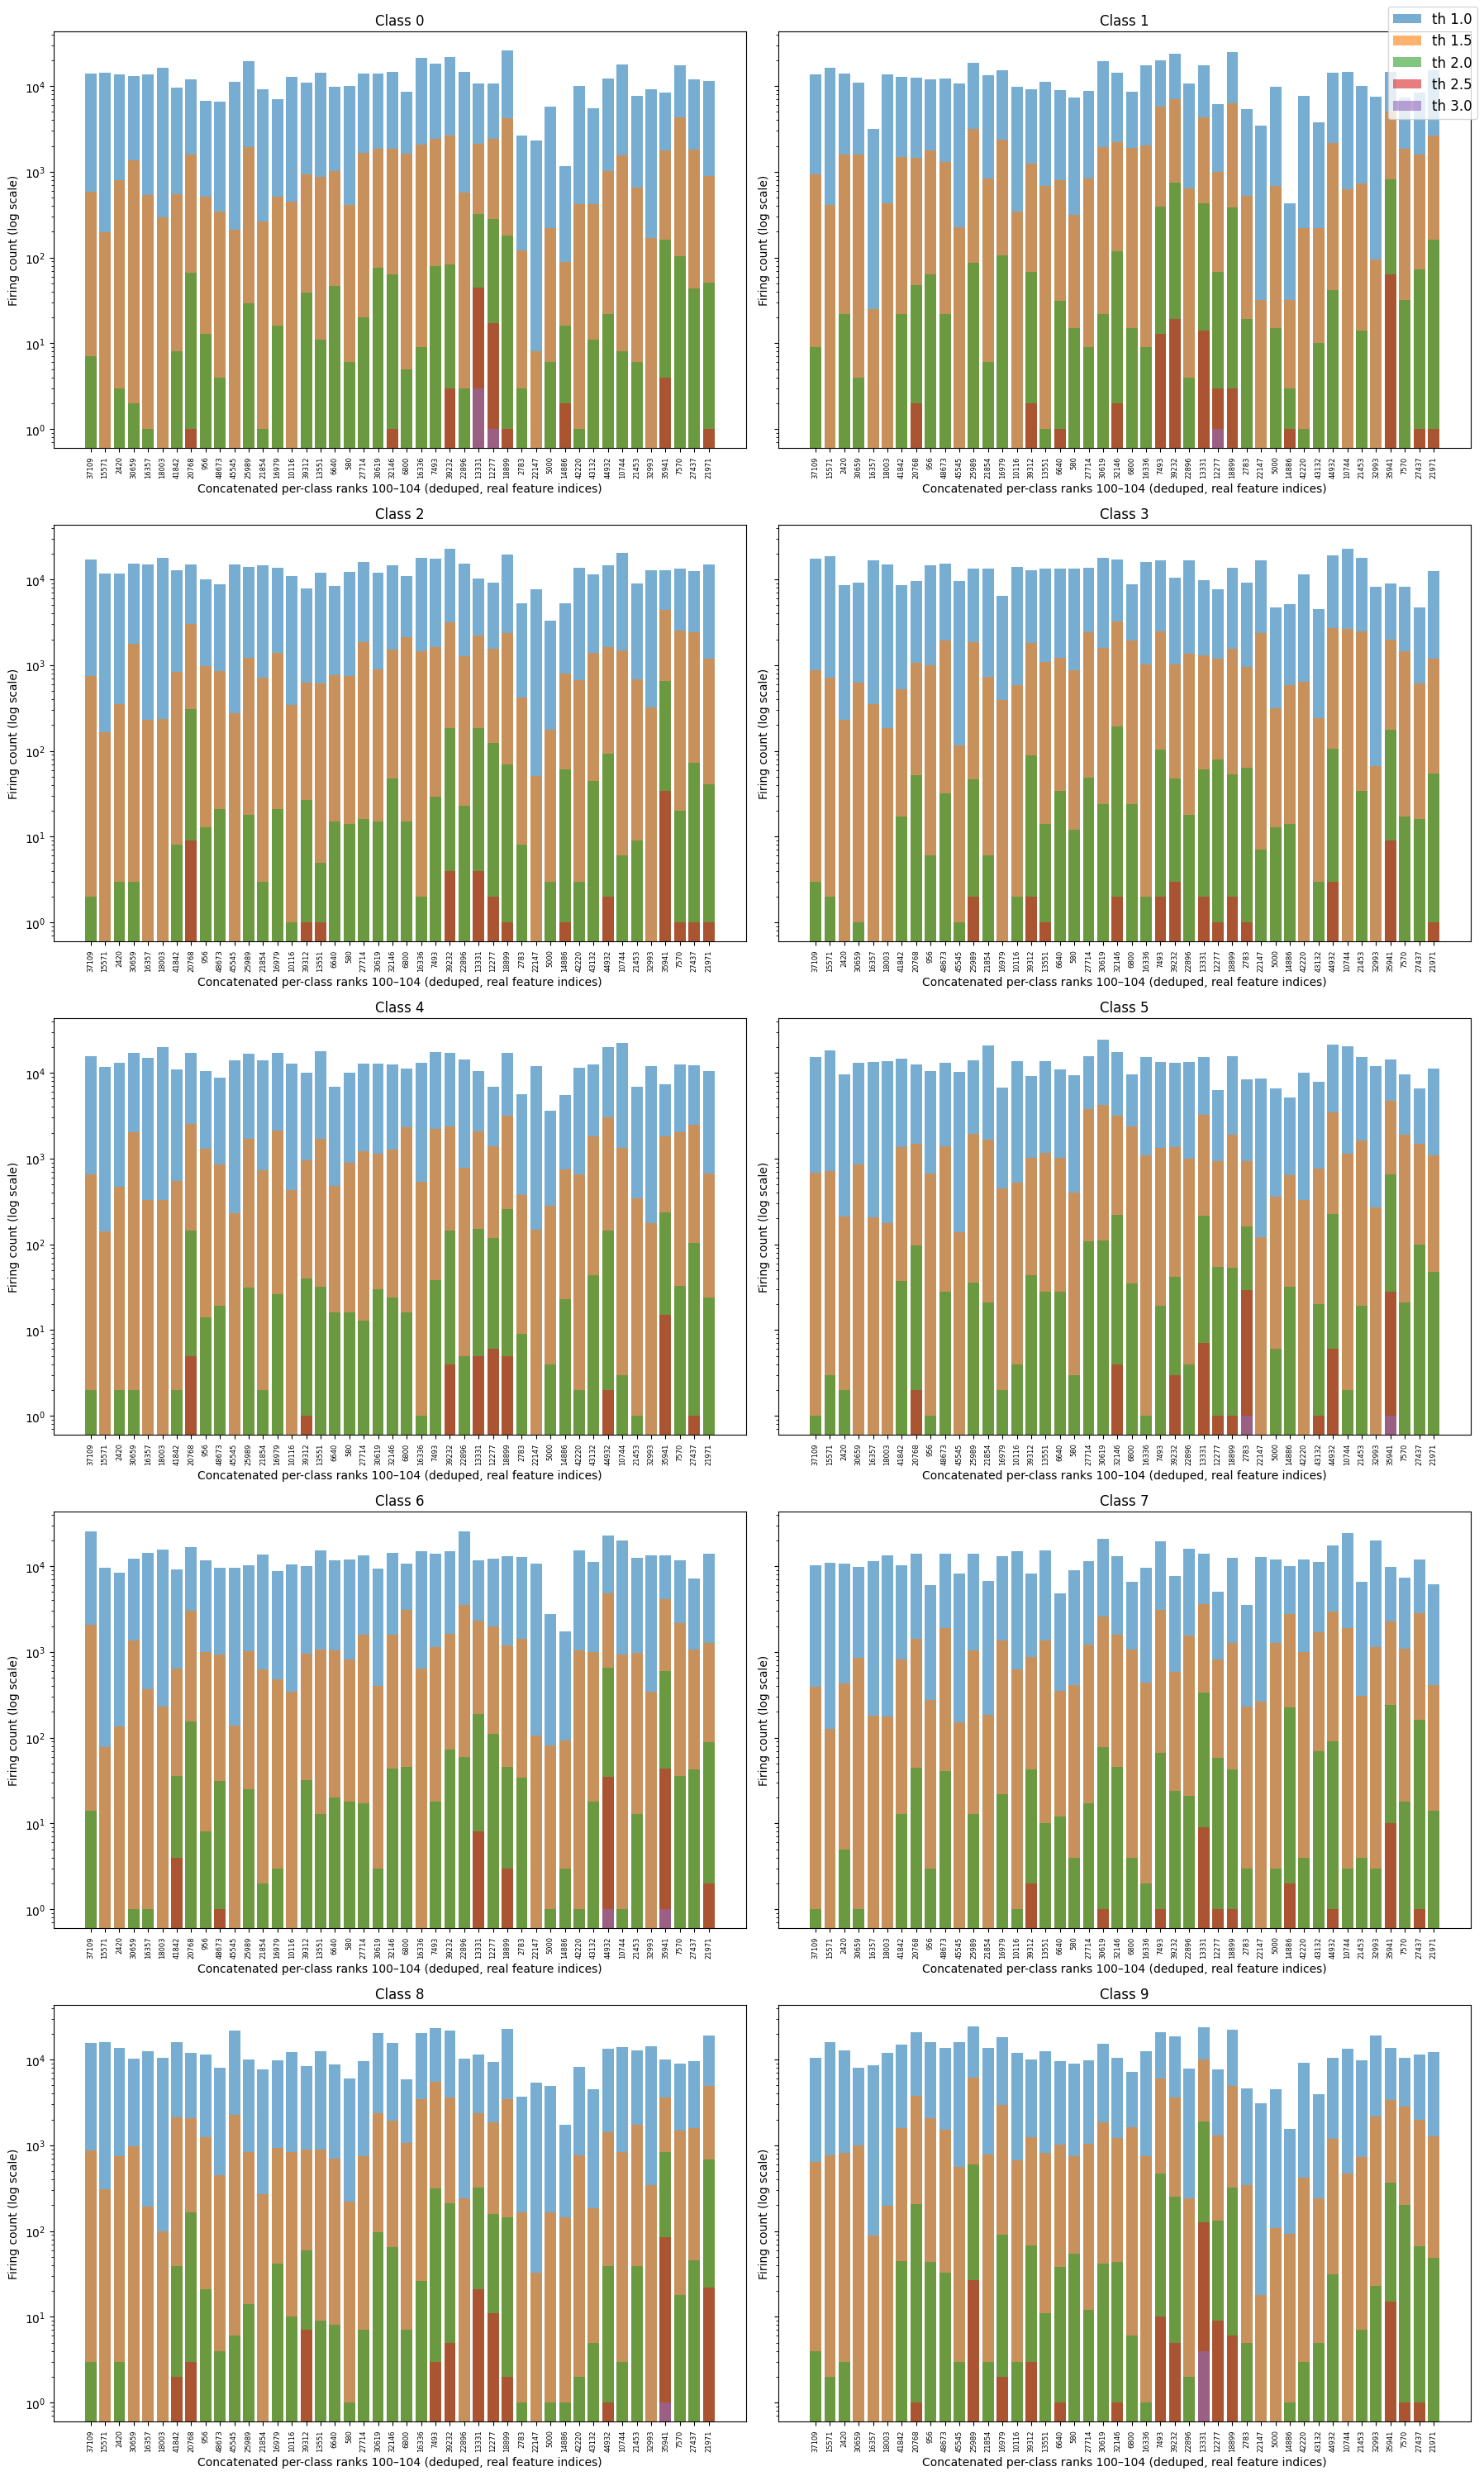

In [61]:
plot_per_class_rank_range_concat(counts,thresholds,100, 105)

Deduped concatenation size = 42 features (from ranks 165-169 of each class)


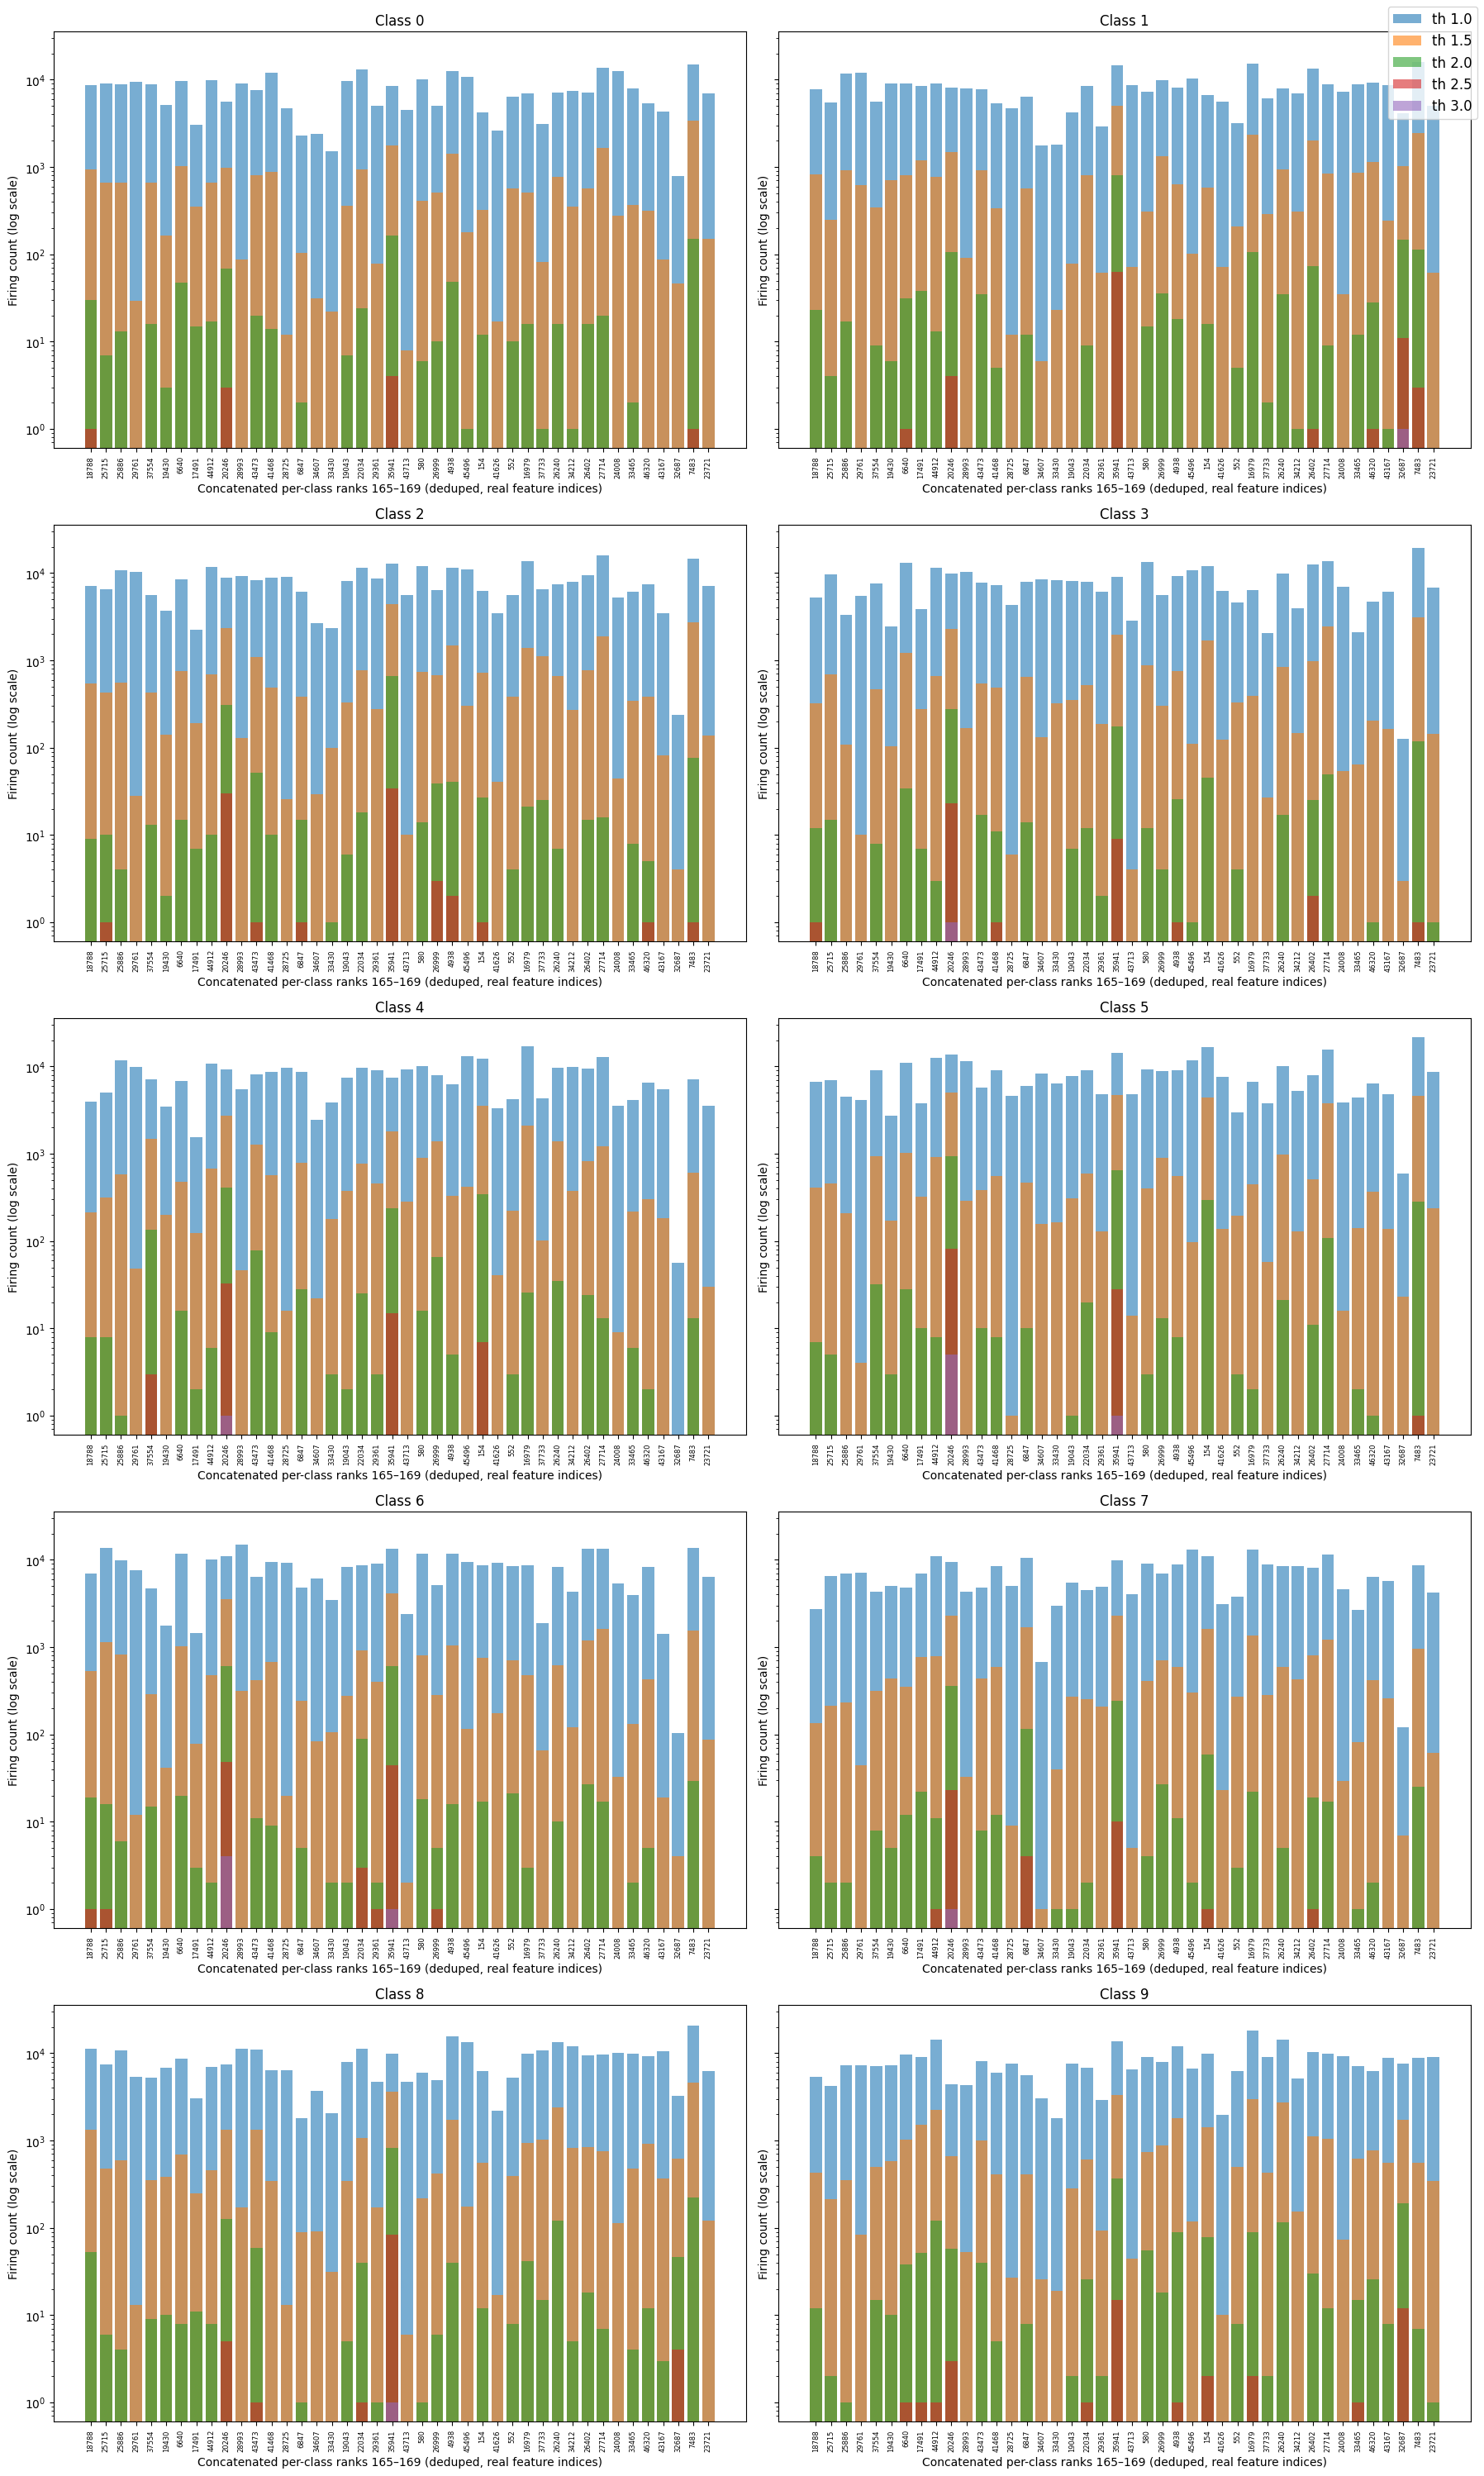

In [62]:
plot_per_class_rank_range_concat(counts,thresholds,165, 170)

Deduped concatenation size = 47 features (from ranks 185-189 of each class)


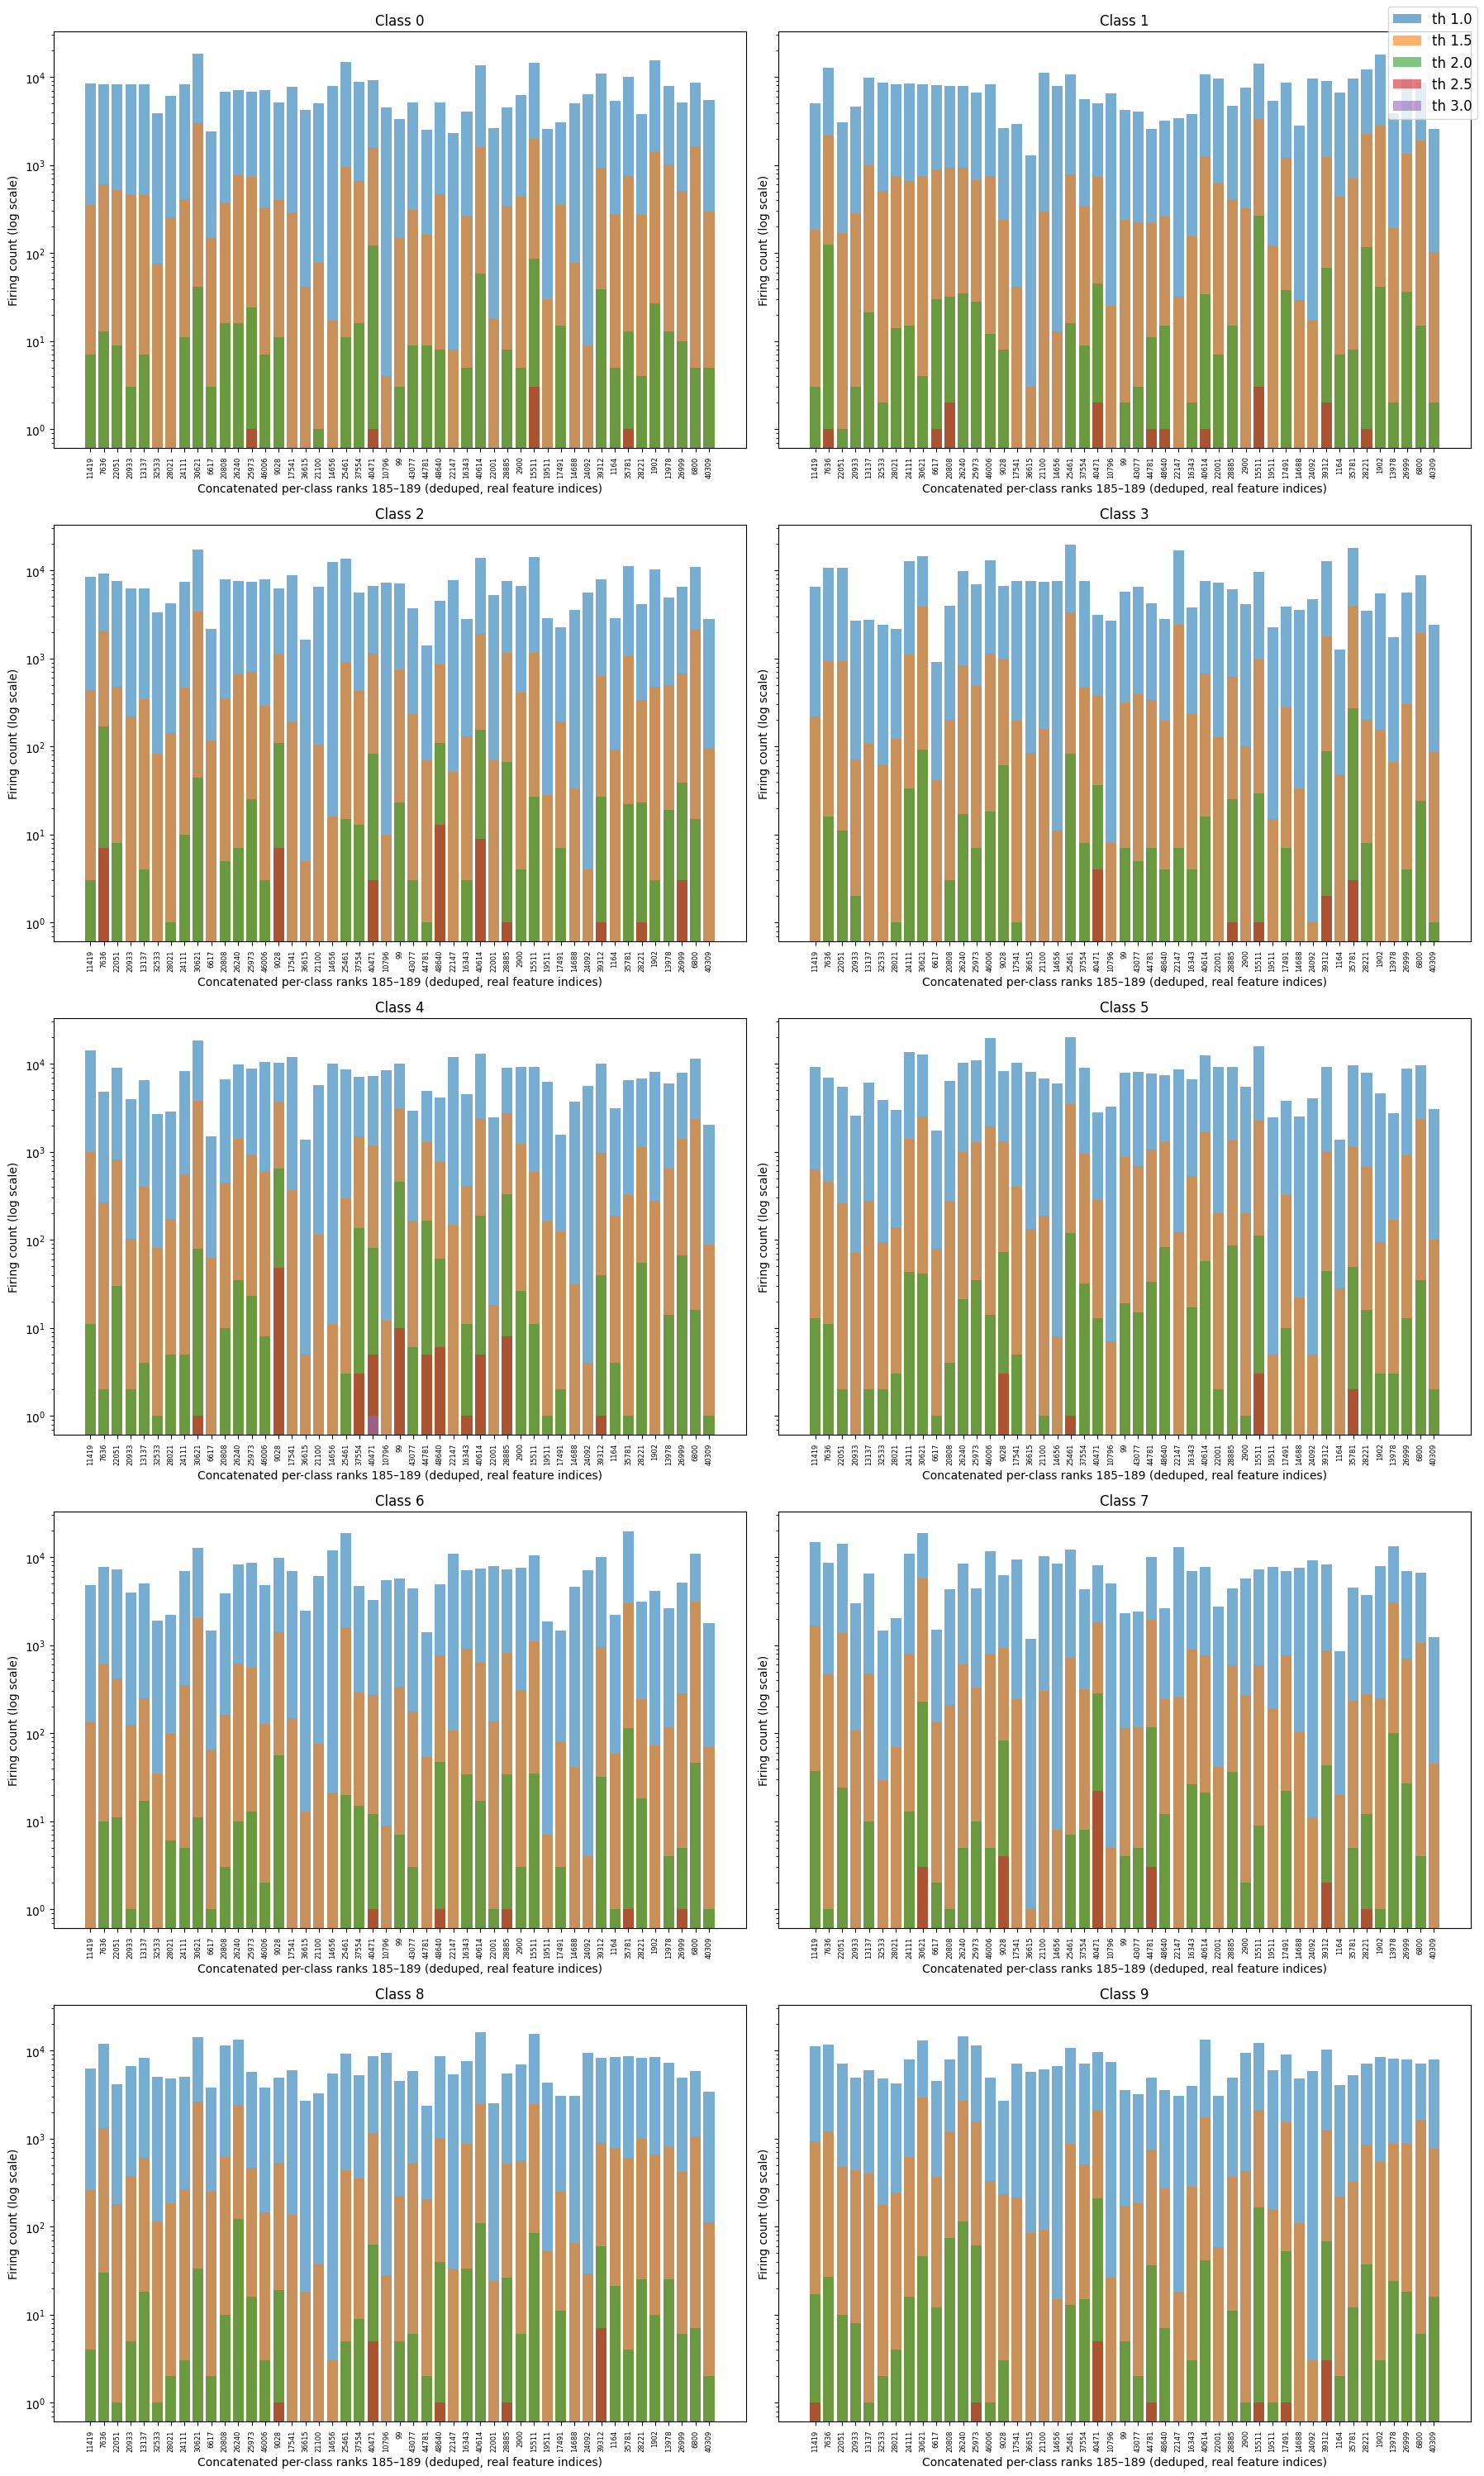

In [63]:
plot_per_class_rank_range_concat(counts,thresholds,185, 190)

In [114]:
import numpy as np

def compute_l1_matrices_localrank_dedup(
    counts_dict,
    thresholds=[1.5, 2.0, 2.5],
    ranges=[(100,105), (165,170), (185,190)]
):
    """
    1. For each class, compute its LOCAL ranking of features.
    2. From each range, extract locally ranked features.
    3. Concatenate across classes but DEDUPE WHILE PRESERVING ORDER.
    4. For each threshold and each deduped feature, compute:
           M[i,j] = |count(class_i, f) - count(class_j, f)|
    Returns:
        deduped_features : list of feature indices in preserved order
        results[threshold][feature_index] = class x class L1 matrix
    """

    # helper to ensure numpy
    def to_numpy(x):
        try:
            return x.cpu().numpy()
        except AttributeError:
            return np.asarray(x)

    classes = sorted(counts_dict[thresholds[0]].keys())
    num_classes = len(classes)

    # ---------------------------------------------------------
    # STEP 1 — Collect local-rank features for each class
    # ---------------------------------------------------------
    ordered_unique = []
    seen = set()

    for cls in classes:

        # Aggregate across thresholds *per class* to produce local ranks
        example_th = thresholds[0]
        vec_example = to_numpy(counts_dict[example_th][cls])
        num_features = vec_example.shape[0]

        combined = np.zeros(num_features)
        for th in thresholds:
            combined += to_numpy(counts_dict[th][cls])

        # LOCAL per-class ranking
        local_rank = np.argsort(-combined)

        # Extract requested ranges
        for (rs, re) in ranges:
            slice_feats = local_rank[rs:re]

            # Deduped concatenation
            for f in slice_feats:
                if f not in seen:
                    seen.add(f)
                    ordered_unique.append(f)

    deduped_features = ordered_unique
    M = len(deduped_features)

    # ---------------------------------------------------------
    # STEP 2 — Build per-threshold matrices for these deduped features
    # ---------------------------------------------------------
    results = {th: {} for th in thresholds}

    for th in thresholds:

        # Preload per-class feature values for this threshold
        class_feature_counts = []
        for cls in classes:
            class_feature_counts.append(to_numpy(counts_dict[th][cls]))

        class_feature_counts = np.vstack(class_feature_counts)  # shape (C, F)

        # For each deduped feature → compute class×class L1 matrix
        for f in deduped_features:
            v = class_feature_counts[:, f]  # shape (num_classes,)
            diff = np.abs(v[:, None] - v[None, :])
            results[th][f] = diff

    return deduped_features, results


In [116]:
_, results = compute_l1_matrices_localrank_dedup(
    counts_dict=counts,
    thresholds=[1.5, 2.0, 2.5],
    ranges=[(100,105), (165,170), (185,190)]
)

results

{1.5: {np.int64(26516): array([[   0,   14,  507,  534,  686,  452,  661,  342,  694, 1169],
         [  14,    0,  521,  548,  700,  466,  675,  356,  680, 1155],
         [ 507,  521,    0,   27,  179,   55,  154,  165, 1201, 1676],
         [ 534,  548,   27,    0,  152,   82,  127,  192, 1228, 1703],
         [ 686,  700,  179,  152,    0,  234,   25,  344, 1380, 1855],
         [ 452,  466,   55,   82,  234,    0,  209,  110, 1146, 1621],
         [ 661,  675,  154,  127,   25,  209,    0,  319, 1355, 1830],
         [ 342,  356,  165,  192,  344,  110,  319,    0, 1036, 1511],
         [ 694,  680, 1201, 1228, 1380, 1146, 1355, 1036,    0,  475],
         [1169, 1155, 1676, 1703, 1855, 1621, 1830, 1511,  475,    0]]),
  np.int64(22591): array([[  0, 796, 858, 452, 867, 797, 437, 678, 857, 160],
         [796,   0,  62, 344,  71,   1, 359, 118,  61, 636],
         [858,  62,   0, 406,   9,  61, 421, 180,   1, 698],
         [452, 344, 406,   0, 415, 345,  15, 226, 405, 292],
     

In [117]:
import numpy as np

def compute_relative_sparsity_for_results(
    results,
    tau_scale=0.3
):
    """
    Given:
        results[threshold][feature] = class x class L1 difference matrix

    Computes:
        sparsity[threshold][feature] = relative_sparsity

    where:
        tau = tau_scale * max(|A|)
        relative_sparsity = mean(|A| < tau)
    """

    sparsity = {th: {} for th in results.keys()}

    for th, feature_dict in results.items():
        for feat, A in feature_dict.items():

            # A is class × class matrix
            max_val = np.max(np.abs(A))
            tau = tau_scale * max_val

            rel_sparsity = np.mean(np.abs(A) < tau)

            sparsity[th][feat] = rel_sparsity

    return sparsity

In [119]:
sparsity = compute_relative_sparsity_for_results(results)
sparsity

{1.5: {np.int64(26516): np.float64(0.6),
  np.int64(22591): np.float64(0.48),
  np.int64(18704): np.float64(0.5),
  np.int64(5972): np.float64(0.54),
  np.int64(20762): np.float64(0.52),
  np.int64(43159): np.float64(0.68),
  np.int64(46561): np.float64(0.46),
  np.int64(7636): np.float64(0.46),
  np.int64(26984): np.float64(0.58),
  np.int64(6553): np.float64(0.48),
  np.int64(39479): np.float64(0.6),
  np.int64(956): np.float64(0.52),
  np.int64(16979): np.float64(0.42),
  np.int64(22051): np.float64(0.6),
  np.int64(39831): np.float64(0.66),
  np.int64(2420): np.float64(0.6),
  np.int64(30659): np.float64(0.52),
  np.int64(38585): np.float64(0.42),
  np.int64(20246): np.float64(0.56),
  np.int64(19030): np.float64(0.64),
  np.int64(22034): np.float64(0.52),
  np.int64(41509): np.float64(0.52),
  np.int64(47095): np.float64(0.62),
  np.int64(25461): np.float64(0.64),
  np.int64(44099): np.float64(0.58),
  np.int64(19430): np.float64(0.5),
  np.int64(35781): np.float64(0.68),
  np.int

In [122]:
def top_k_percent_sparsity(sparsity_dict, k_percent=30):
    """
    sparsity_dict[threshold][feature] = sparsity_value

    Returns:
       top_features[threshold] = [(feature, sparsity_value), ...]
       sorted from highest sparsity → lowest among the top k%.

    k_percent: e.g. 10 means top 10% highest sparsity values.
    """

    top_features = {}

    for th, feature_dict in sparsity_dict.items():

        # Convert dict → list of (feature, sparsity)
        items = list(feature_dict.items())   # [(feat, val), ...]

        # Sort by sparsity descending (highest sparsity first)
        items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

        # Compute cutoff count
        n = len(items_sorted)
        k = max(1, int(n * (k_percent / 100.0)))

        # Take top k%
        top_features[th] = items_sorted[:k]

    return top_features

In [129]:
top_k_sparsity = top_k_percent_sparsity(sparsity, k_percent=10)

In [124]:
def union_of_topk_features(topk_dict):
    """
    topk_dict[threshold] = [(feature, sparsity_value), ...]

    Returns:
        union_features : set of all feature indices across thresholds
        n_union        : length of the union (int)
    """

    union_set = set()

    for th, items in topk_dict.items():
        for feat, sparsity_val in items:
            union_set.add(feat)

    return union_set, len(union_set)

In [131]:
features, union_length = union_of_topk_features(top_k_sparsity)
print(features)

{np.int64(25989), np.int64(8709), np.int64(20359), np.int64(44551), np.int64(47241), np.int64(40471), np.int64(13978), np.int64(29216), np.int64(1064), np.int64(43948), np.int64(5167), np.int64(24248), np.int64(6847), np.int64(31041), np.int64(9028), np.int64(29390), np.int64(2642), np.int64(21971), np.int64(7636), np.int64(16979), np.int64(19030), np.int64(10216), np.int64(2420), np.int64(25461)}


In [135]:
featuress = [int(x) for x in features]
featuress

[25989,
 8709,
 20359,
 44551,
 47241,
 40471,
 13978,
 29216,
 1064,
 43948,
 5167,
 24248,
 6847,
 31041,
 9028,
 29390,
 2642,
 21971,
 7636,
 16979,
 19030,
 10216,
 2420,
 25461]